## Set up Environment

### Run in terminal

conda create --name fire python=3.9.13

conda activate fire

conda install -y jupyter pandas numpy matplotlib geopandas seaborn xarray numpy glob2 rioxarray scipy

or

pip install jupyter pandas numpy matplotlib geopandas seaborn xarray numpy glob2 rioxarray scipy contextily

pip install rtree netcdf4

jupyter notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import pickle as pkl
import pandas as pd
import xarray as xr
import numpy as np
import os
import glob
import warnings
import rioxarray
from shapely.geometry import mapping, Point, Polygon
warnings.filterwarnings('ignore')
from scipy.spatial.distance import euclidean

plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 600
plt.rcParams['axes.facecolor']='white'
sns.set()

# [Sierra Nevada](https://gis.data.cnra.ca.gov/datasets/727b3cc24f8549759fe946a298dc3a20_0/explore?location=36.354762%2C-118.192418%2C5.00)


minx       miny        maxx       maxy
0 -123.039367  35.064859 -117.735372  41.994914

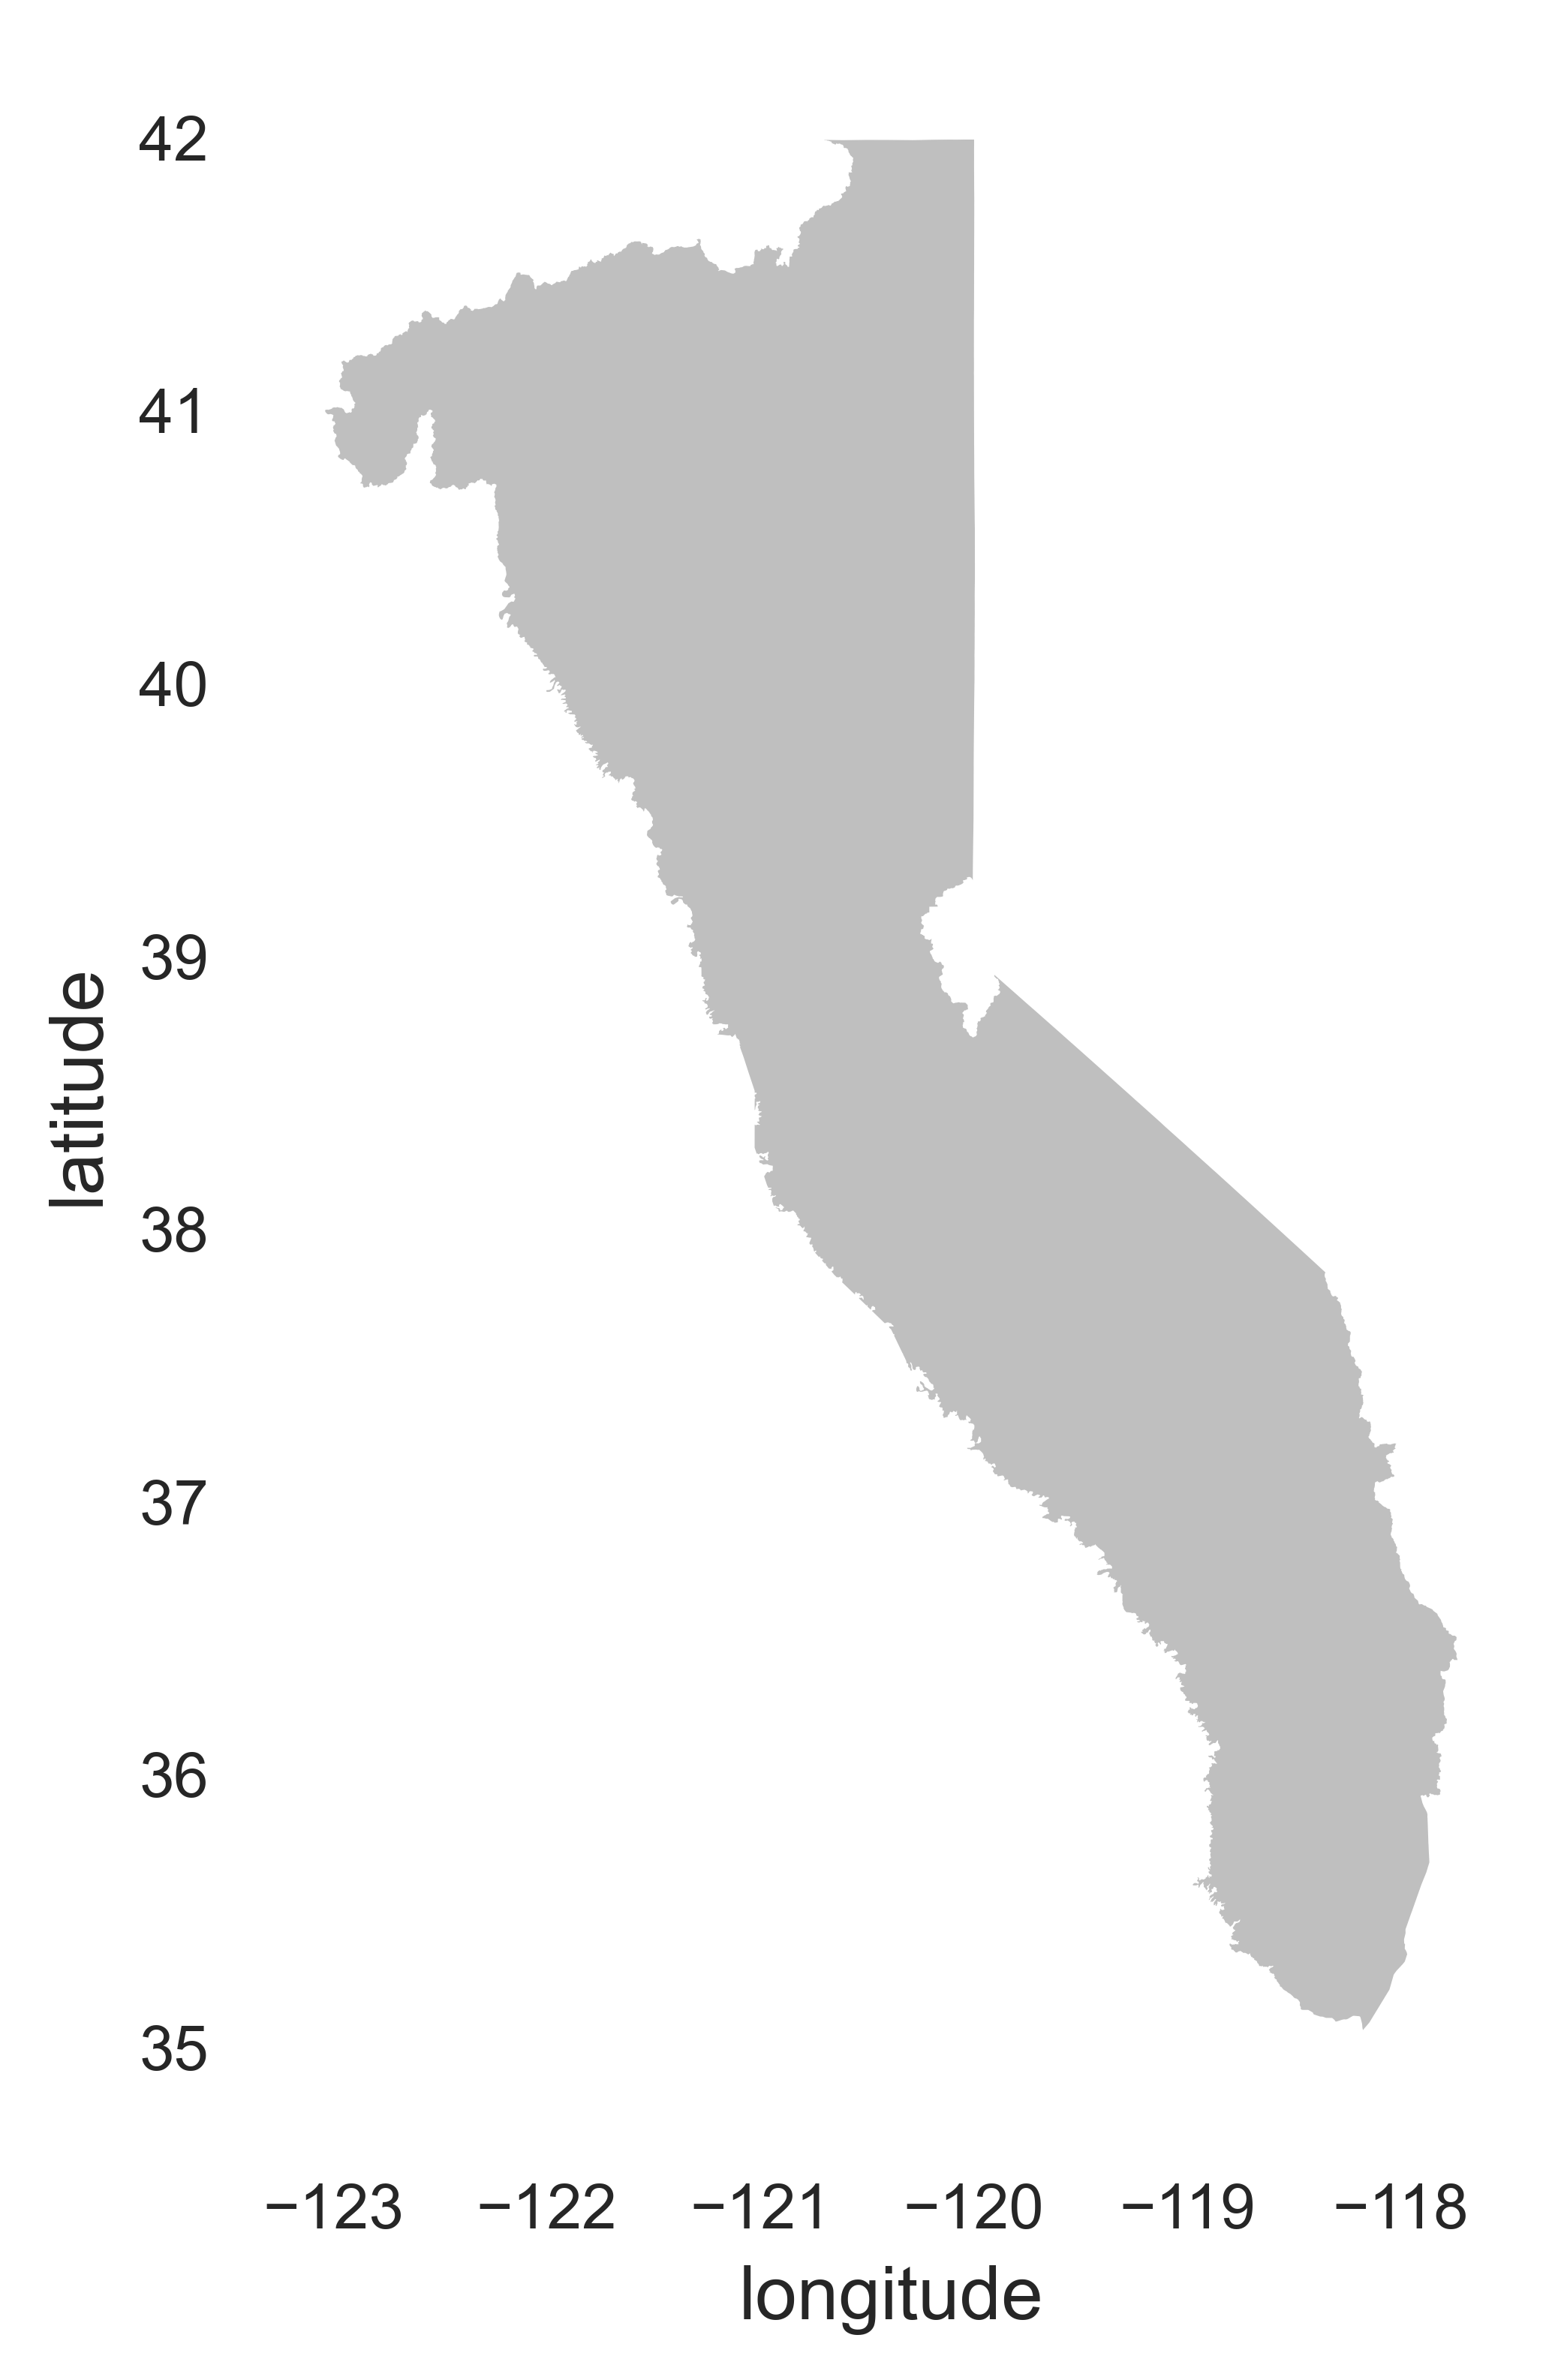

In [2]:
snBoundaries = gpd.GeoDataFrame.from_file(r'zip://data/sierraNevada.zip').to_crs(epsg=4326)
snBounds = snBoundaries.geometry.bounds
display(snBounds)
fig, ax = plt.subplots(nrows=1, ncols=1)
snBoundaries.plot(ax=ax, color='grey', alpha=0.5, linewidth=0);
plt.tick_params(axis='both', which='major', labelsize=10);
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(False);
ax.set_facecolor('white');

## Only Northern Sierra Nevada

Includes Tahoe, Plumas, and Lassen National Forest

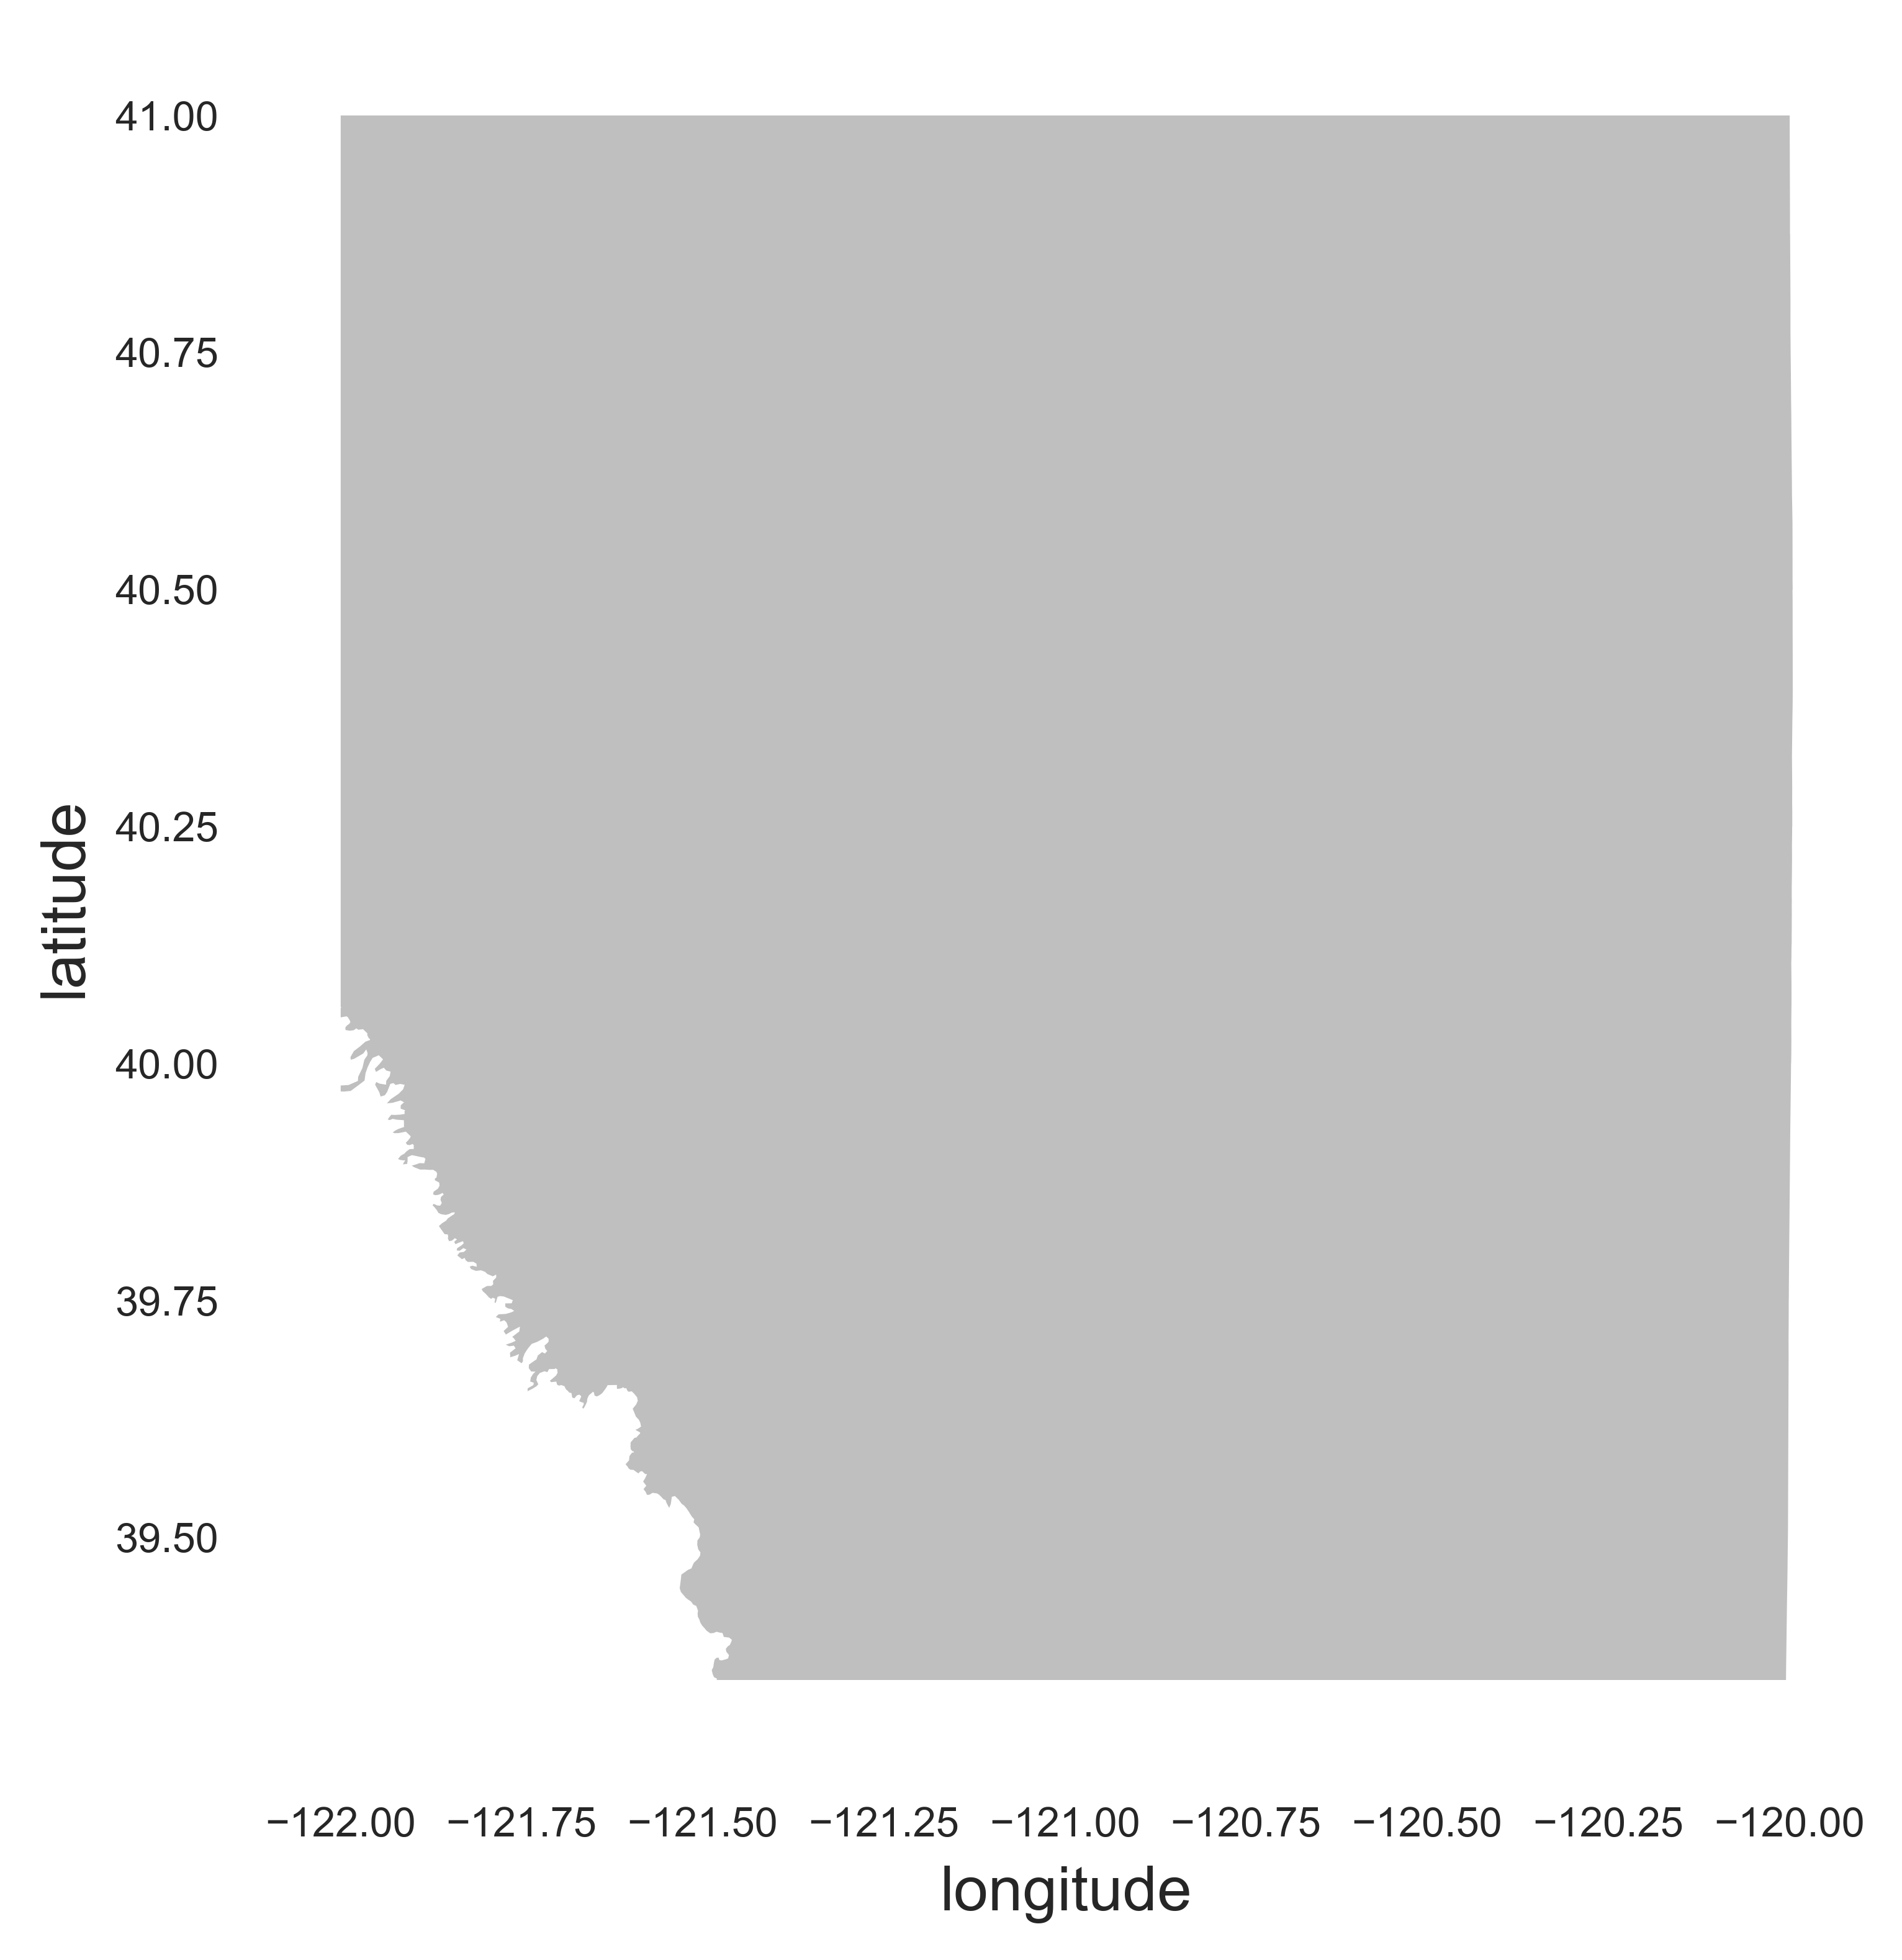

In [3]:
bounds = [-122, 39.35, snBounds.iloc[0].maxx, 41]
boundaries = gpd.clip(snBoundaries, bounds)
bounds = boundaries.geometry.bounds

fig, ax = plt.subplots(nrows=1, ncols=1)
boundaries.plot(ax=ax, color='grey', alpha=0.5, linewidth=0);
plt.tick_params(axis='both', which='major', labelsize=8);
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(False);
ax.set_facecolor('white');

# [Fire Perimeter](https://frap.fire.ca.gov/frap-projects/fire-perimeters/)

|cause code|description|cause code|description|
|:--:|:--|:--:|:--|
|1 |Lightning         |11|Power Line
|2 |Equipment Use     |12|Firefighter Training
|3 |Smoking           |13|Non-Firefighter Training
|4 |Campfire          |14|Unknown/Unidentified
|5 |Debris            |15|Structure
|6 |Railroad          |16|Aircraft
|7 |Arson             |17|Volcanic
|8 |Playing with Fire |18|Escaped Prescribed Burn
|9 |Miscellaneous     |19|Illegal Alien Campfire
|10|Vehicle

In [4]:
# clean data
firePer = gpd.GeoDataFrame.from_file(r'zip://data/fire21_1.gdb.zip').to_crs(epsg=4326)
firePer = firePer[firePer.YEAR_.isin(['2017','2018','2019','2020','2021',])]
firePer = firePer[firePer.STATE == 'CA']
firePer = firePer.dropna(subset=['ALARM_DATE', 'CONT_DATE'])
firePer = gpd.clip(firePer, boundaries) # fires in area
firePer = firePer.drop(index=342) # error date: 0202-08-20
firePer['ALARM_DATE'] = pd.to_datetime(firePer.ALARM_DATE.astype(str).str[:10], format='%Y-%m-%d')
firePer['CONT_DATE']  = pd.to_datetime(firePer.CONT_DATE.astype(str).str[:10], format='%Y-%m-%d')
firePer = firePer.sort_values('ALARM_DATE').reset_index(drop=True)
print(np.sort(firePer.CAUSE.unique()))

[ 1.  2.  5.  7.  8.  9. 10. 11. 14. 18. nan]


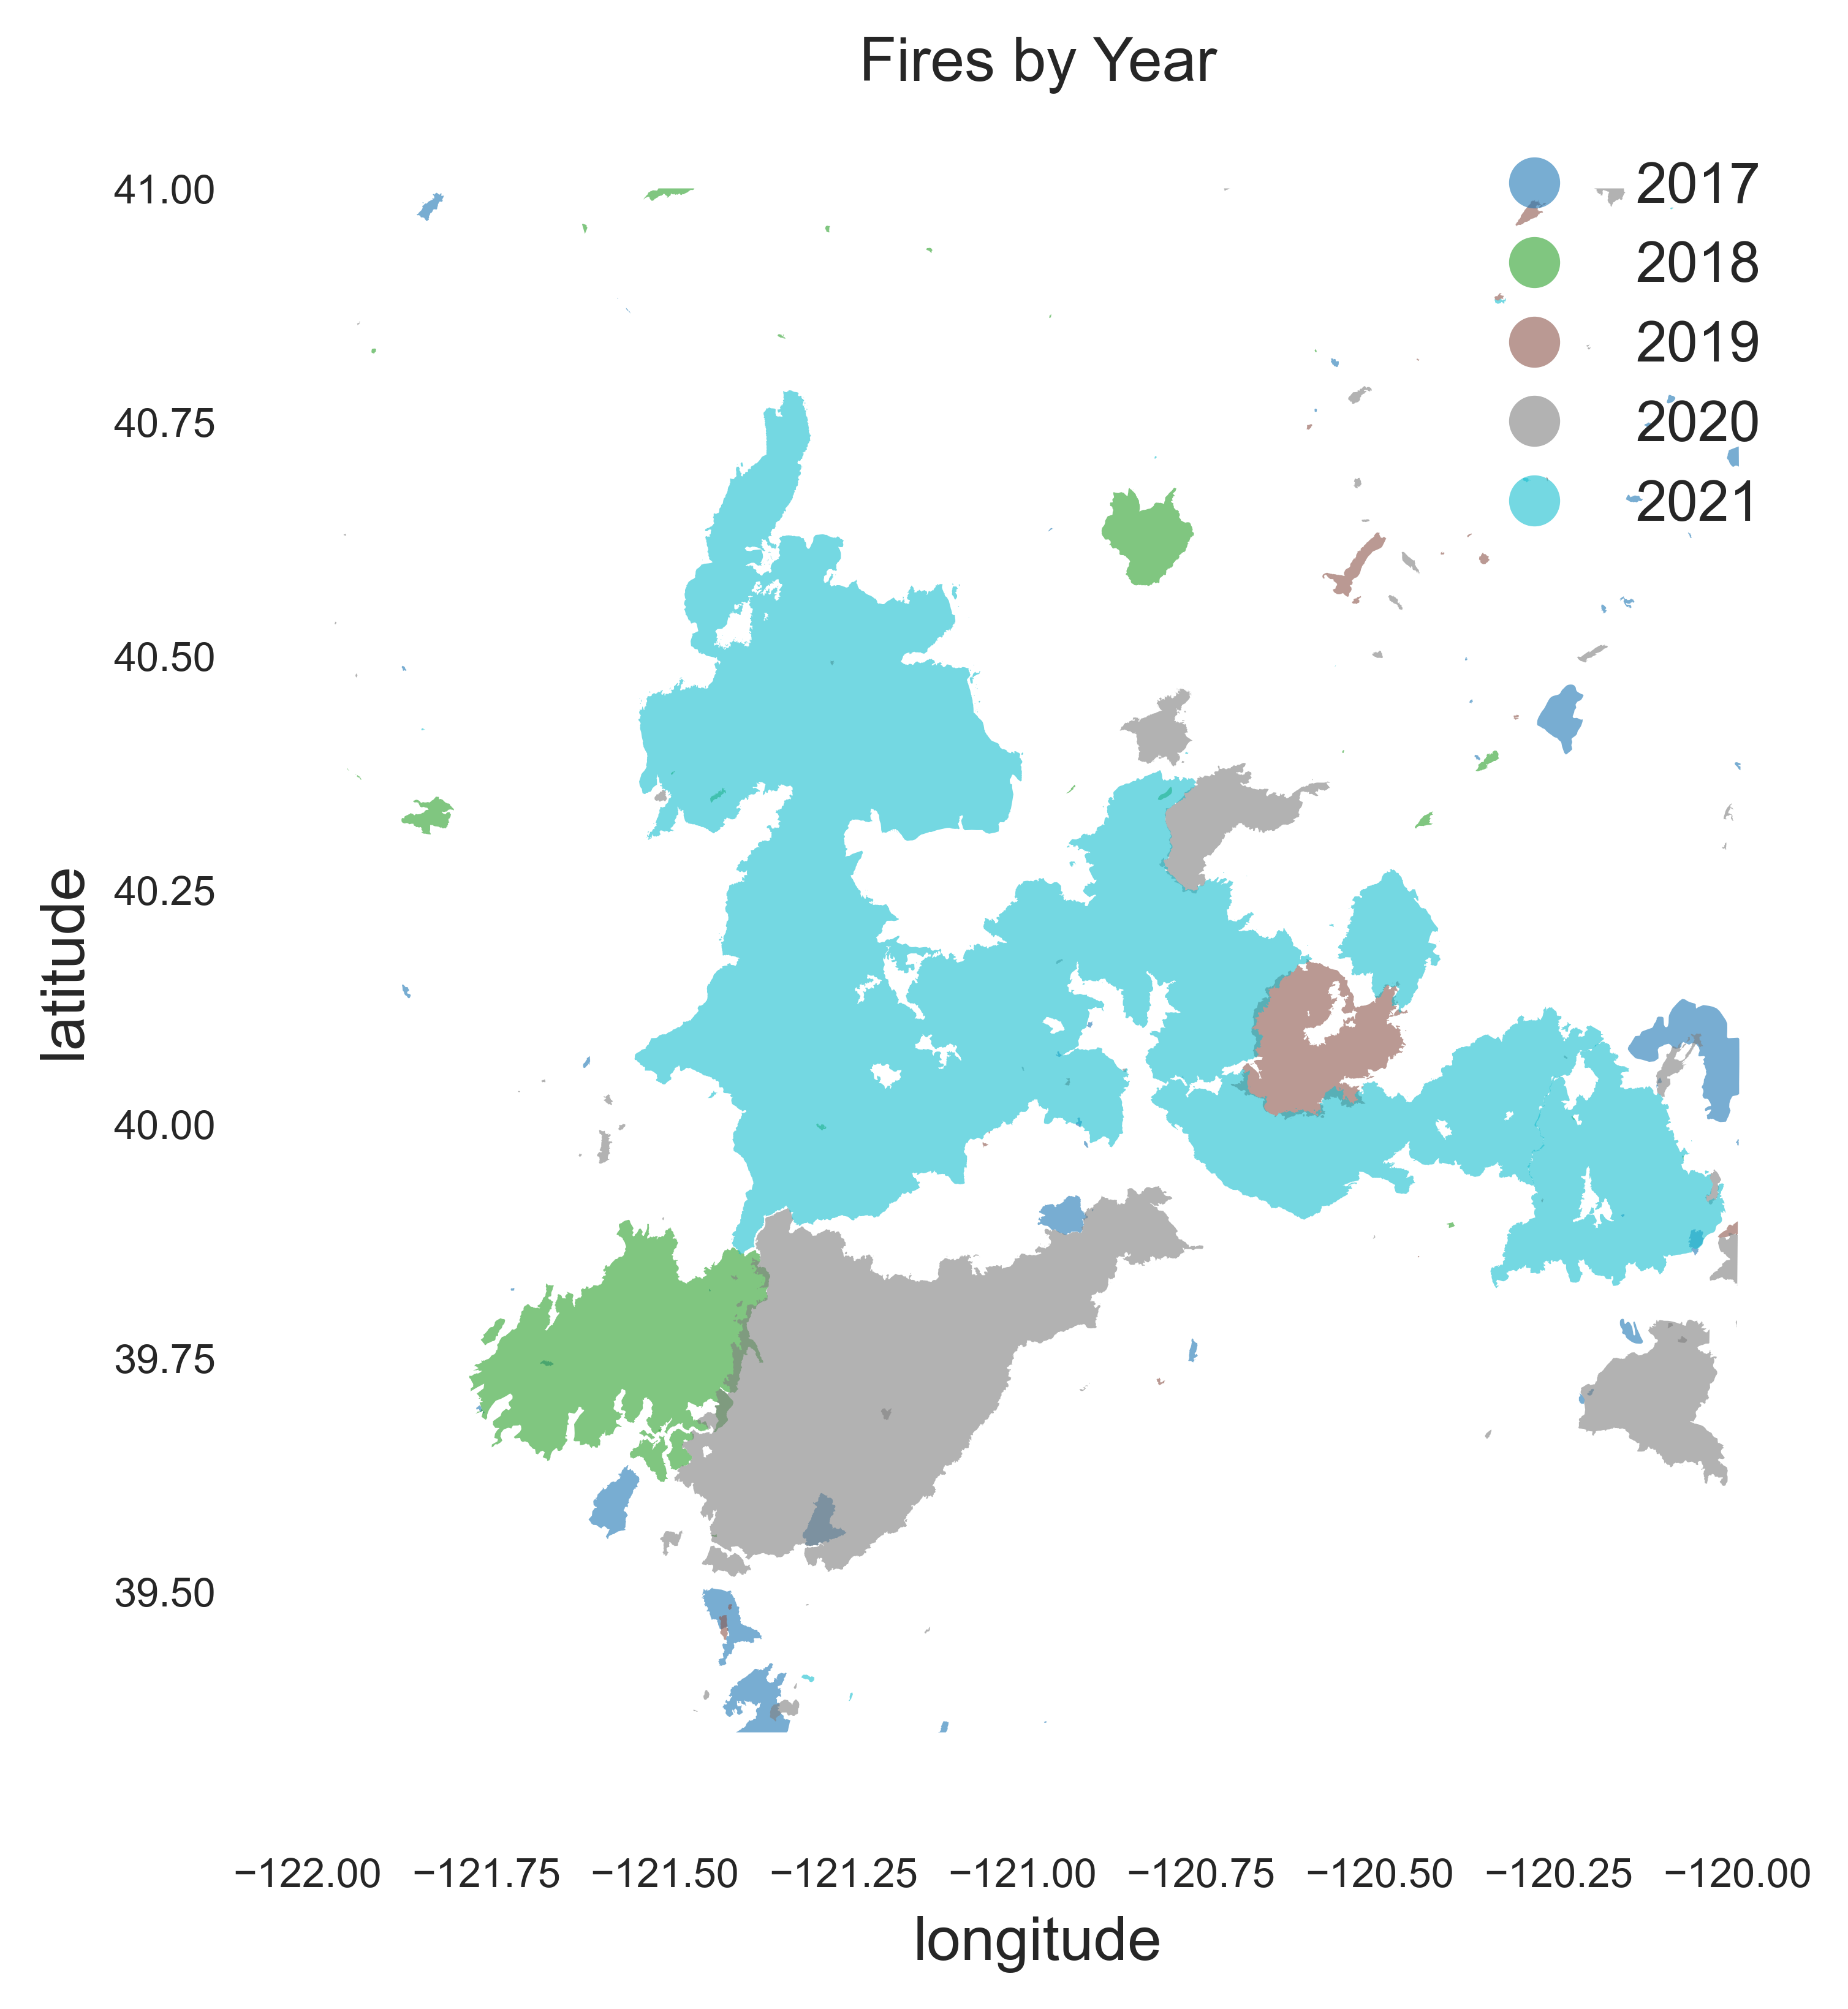

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)
firePer.plot('YEAR_', legend=True, alpha=0.6, linewidth=0, ax=ax);
plt.title('Fires by Year');
plt.tick_params(axis='both', which='major', labelsize=8);
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(False);
ax.set_facecolor('white');

In [6]:
firePer.sort_values('Shape_Area', ascending=False).head()

YEAR_ STATE AGENCY UNIT_ID         FIRE_NAME   INC_NUM ALARM_DATE  \
147  2021    CA    CDF     BTU             DIXIE  00009205 2021-07-14   
130  2020    CA    USF     PNF     NORTH COMPLEX  00001302 2020-08-17   
69   2018    CA    CDF     BTU              CAMP  00016737 2018-11-08   
146  2021    CA    USF     PNF             SUGAR  00001046 2021-07-02   
132  2020    CA    BLM     NOD  W-5 COLD SPRINGS  00004727 2020-08-18   

     CONT_DATE  CAUSE                                           COMMENTS  \
147 2021-10-25   11.0  E9DB628D-DFB7-4C85-BCD6-1254574D946B, contains...   
130 2020-12-03    1.0               76D31198-0DB2-4ED3-8A95-85F24964E547   
69  2018-11-26   11.0                                                      
146 2021-10-28   14.0  33088F36-F802-4500-86A4-82DA6A62425F, Beckwourth    
132 2020-09-13    1.0               0afebc32-36ee-4fa8-aec5-419c9c6ba51d   

     REPORT_AC      GIS_ACRES  C_METHOD  OBJECTIVE FIRE_NUM  Shape_Length  \
147   963309.0  963405.437500       7.0        1.0     None  1.533820e+06   
130   318776.0  318797.250000       1.0        1.0     None  3.958365e+05   
69    153336.0  153335.562500       1.0        1.0     None  3.119353e+05   
146   105076.0  105003.906250       7.0        1.0     None  2.251159e+05   
132        NaN   84817.601562       7.0        1.0     None  1.647353e+05   

       Shape_Area                                           geometry  
147  3.898763e+09  MULTIPOLYGON (((-121.08901 40.32212, -121.0889...  
130  1.290127e+09  MULTIPOLYGON (((-121.23012 39.53605, -121.2302...  
69   6.205270e+08  MULTIPOLYGON (((-121.50526 39.66610, -121.5052...  
146  4.249357e+08  MULTIPOLYGON (((-120.20580 39.93242, -120.2062...  
132  3.432446e+08  POLYGON ((-120.15867 40.99911, -120.15834 40.9...

# GRIDMET

### Resources
- [GRIDMET](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET)
- [Download NetCDF Data](https://www.climatologylab.org/gridmet.html)
- [NFDRS fire danger index](https://www.nwcg.gov/publications/pms437/fire-danger/nfdrs-system-inputs-outputs)

### Description
- What starts a fire? high winds, high temperatures, low humidity
- Years: 2017-2021
- Resolution: 4638.3 meters = 4.6383 km
- The key inputs into the NFDRS model are: fuels, weather, topography and risks. 

| variable | var | units | description |
|:--:|:--:|:--:|:--:|
| relative_humidity | rmin | %   | minimum relative humidity |
| air_temperature   | tmmx | K   | maximum temperature |
| wind_speed        | vs   | m/s | wind velocity at 10m |
| burning_index_g   | bi   | NFDRS fire danger index | burning index | 

#### Download Data
- **brew install wget** in terminal or somewhere else
- won't redownload data if files exist in directory data/gm/

In [7]:
# !ls
%cd data
if not os.path.exists('gm/'): os.makedirs('gm/')
%cd gm
! ../metdata_wget.sh
%cd ../../
# !ls

/Users/eugenia/Documents/Fall 2022/wildfire/gridmet/data
/Users/eugenia/Documents/Fall 2022/wildfire/gridmet/data/gm
/Users/eugenia/Documents/Fall 2022/wildfire/gridmet


In [8]:
def clip(f, res, boundaries=boundaries, x_dim='lon', y_dim='lat', fire=False):
    minLon = bounds.iloc[0].minx - res
    maxLon = bounds.iloc[0].maxx + res
    maxLat = bounds.iloc[0].maxy + res
    minLat = bounds.iloc[0].miny - res
    d = xr.open_dataset(f)
    var = list(d.keys())[0]
    d = d[var].sel(lon=slice(minLon,maxLon), lat=slice(maxLat,minLat))
    if fire==True: boundaries=firePer
    d.rio.write_crs("epsg:4326", inplace=True)
    d.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
    d = d.rio.clip(boundaries.geometry.apply(mapping), 
                   boundaries.crs, drop=False)
    return d

In [9]:
# clip using cropped sierra nevada boundary
# include 1 more pixel on all sides
# gridmet resolution: 1/24 or 4km
res = (2/24) # add 2 pixels to all sides
ds = []
for f in np.sort(glob.glob('data/gm/*.nc')):
    da = clip(f, res)
    da = da.drop('crs')
    ds.append(da)
ds = xr.merge(ds) # merge all gridmet vars
# ds.to_netcdf('data/gridmet.nc')
ds.dims

Frozen({'lon': 52, 'lat': 44, 'day': 1826})

In [10]:
# # clip using fire boundary
# res = (2/24) # add 1 pixel to all sides
# dsFire = []
# for f in np.sort(glob.glob('data/gm/*.nc')):
#     da = clip(f, res, fire=True)
#     da = da.drop('crs')
#     dsFire.append(da)
# dsFire = xr.merge(dsFire) # merge all gridmet vars
# # ds.to_netcdf('data/gridmet.nc')
# dsFire.dims

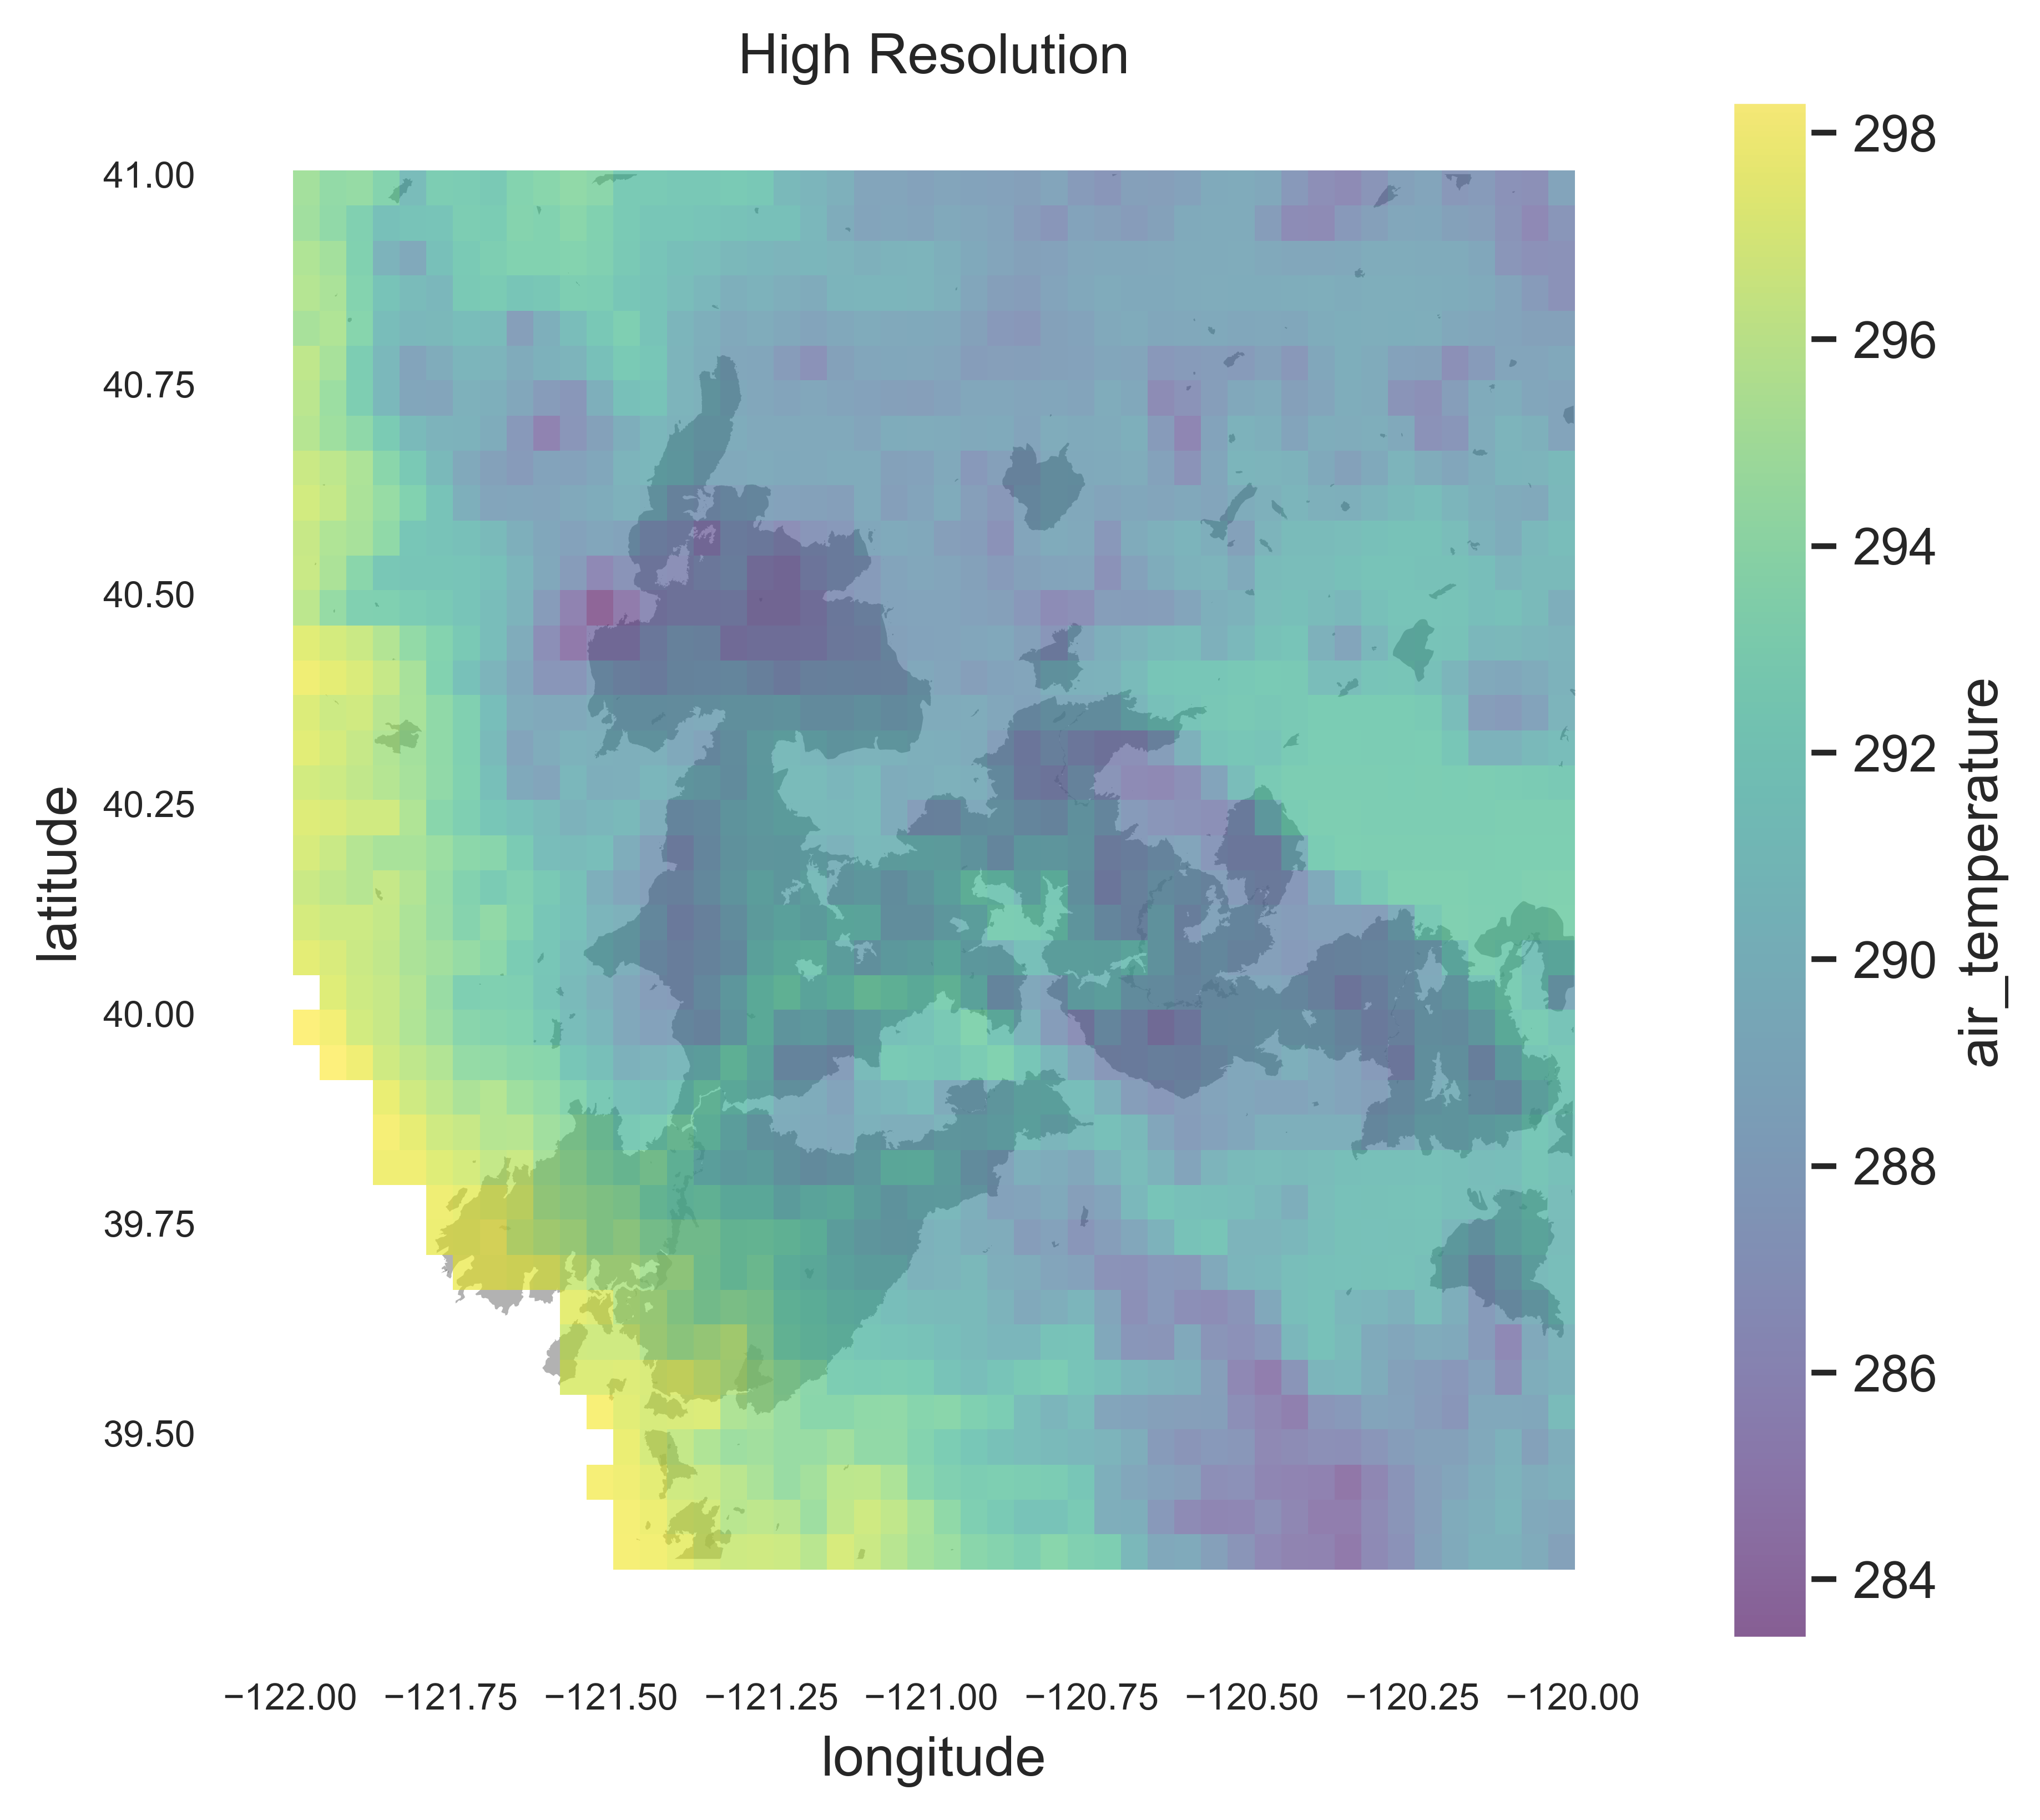

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1)
firePer.plot(alpha=0.6, linewidth=0, color='grey',ax=ax);
ds.air_temperature.mean('day').plot(alpha=0.6, ax=ax);
plt.title('High Resolution');
plt.tick_params(axis='both', which='major', labelsize=8);
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(False);
ax.set_facecolor('white');

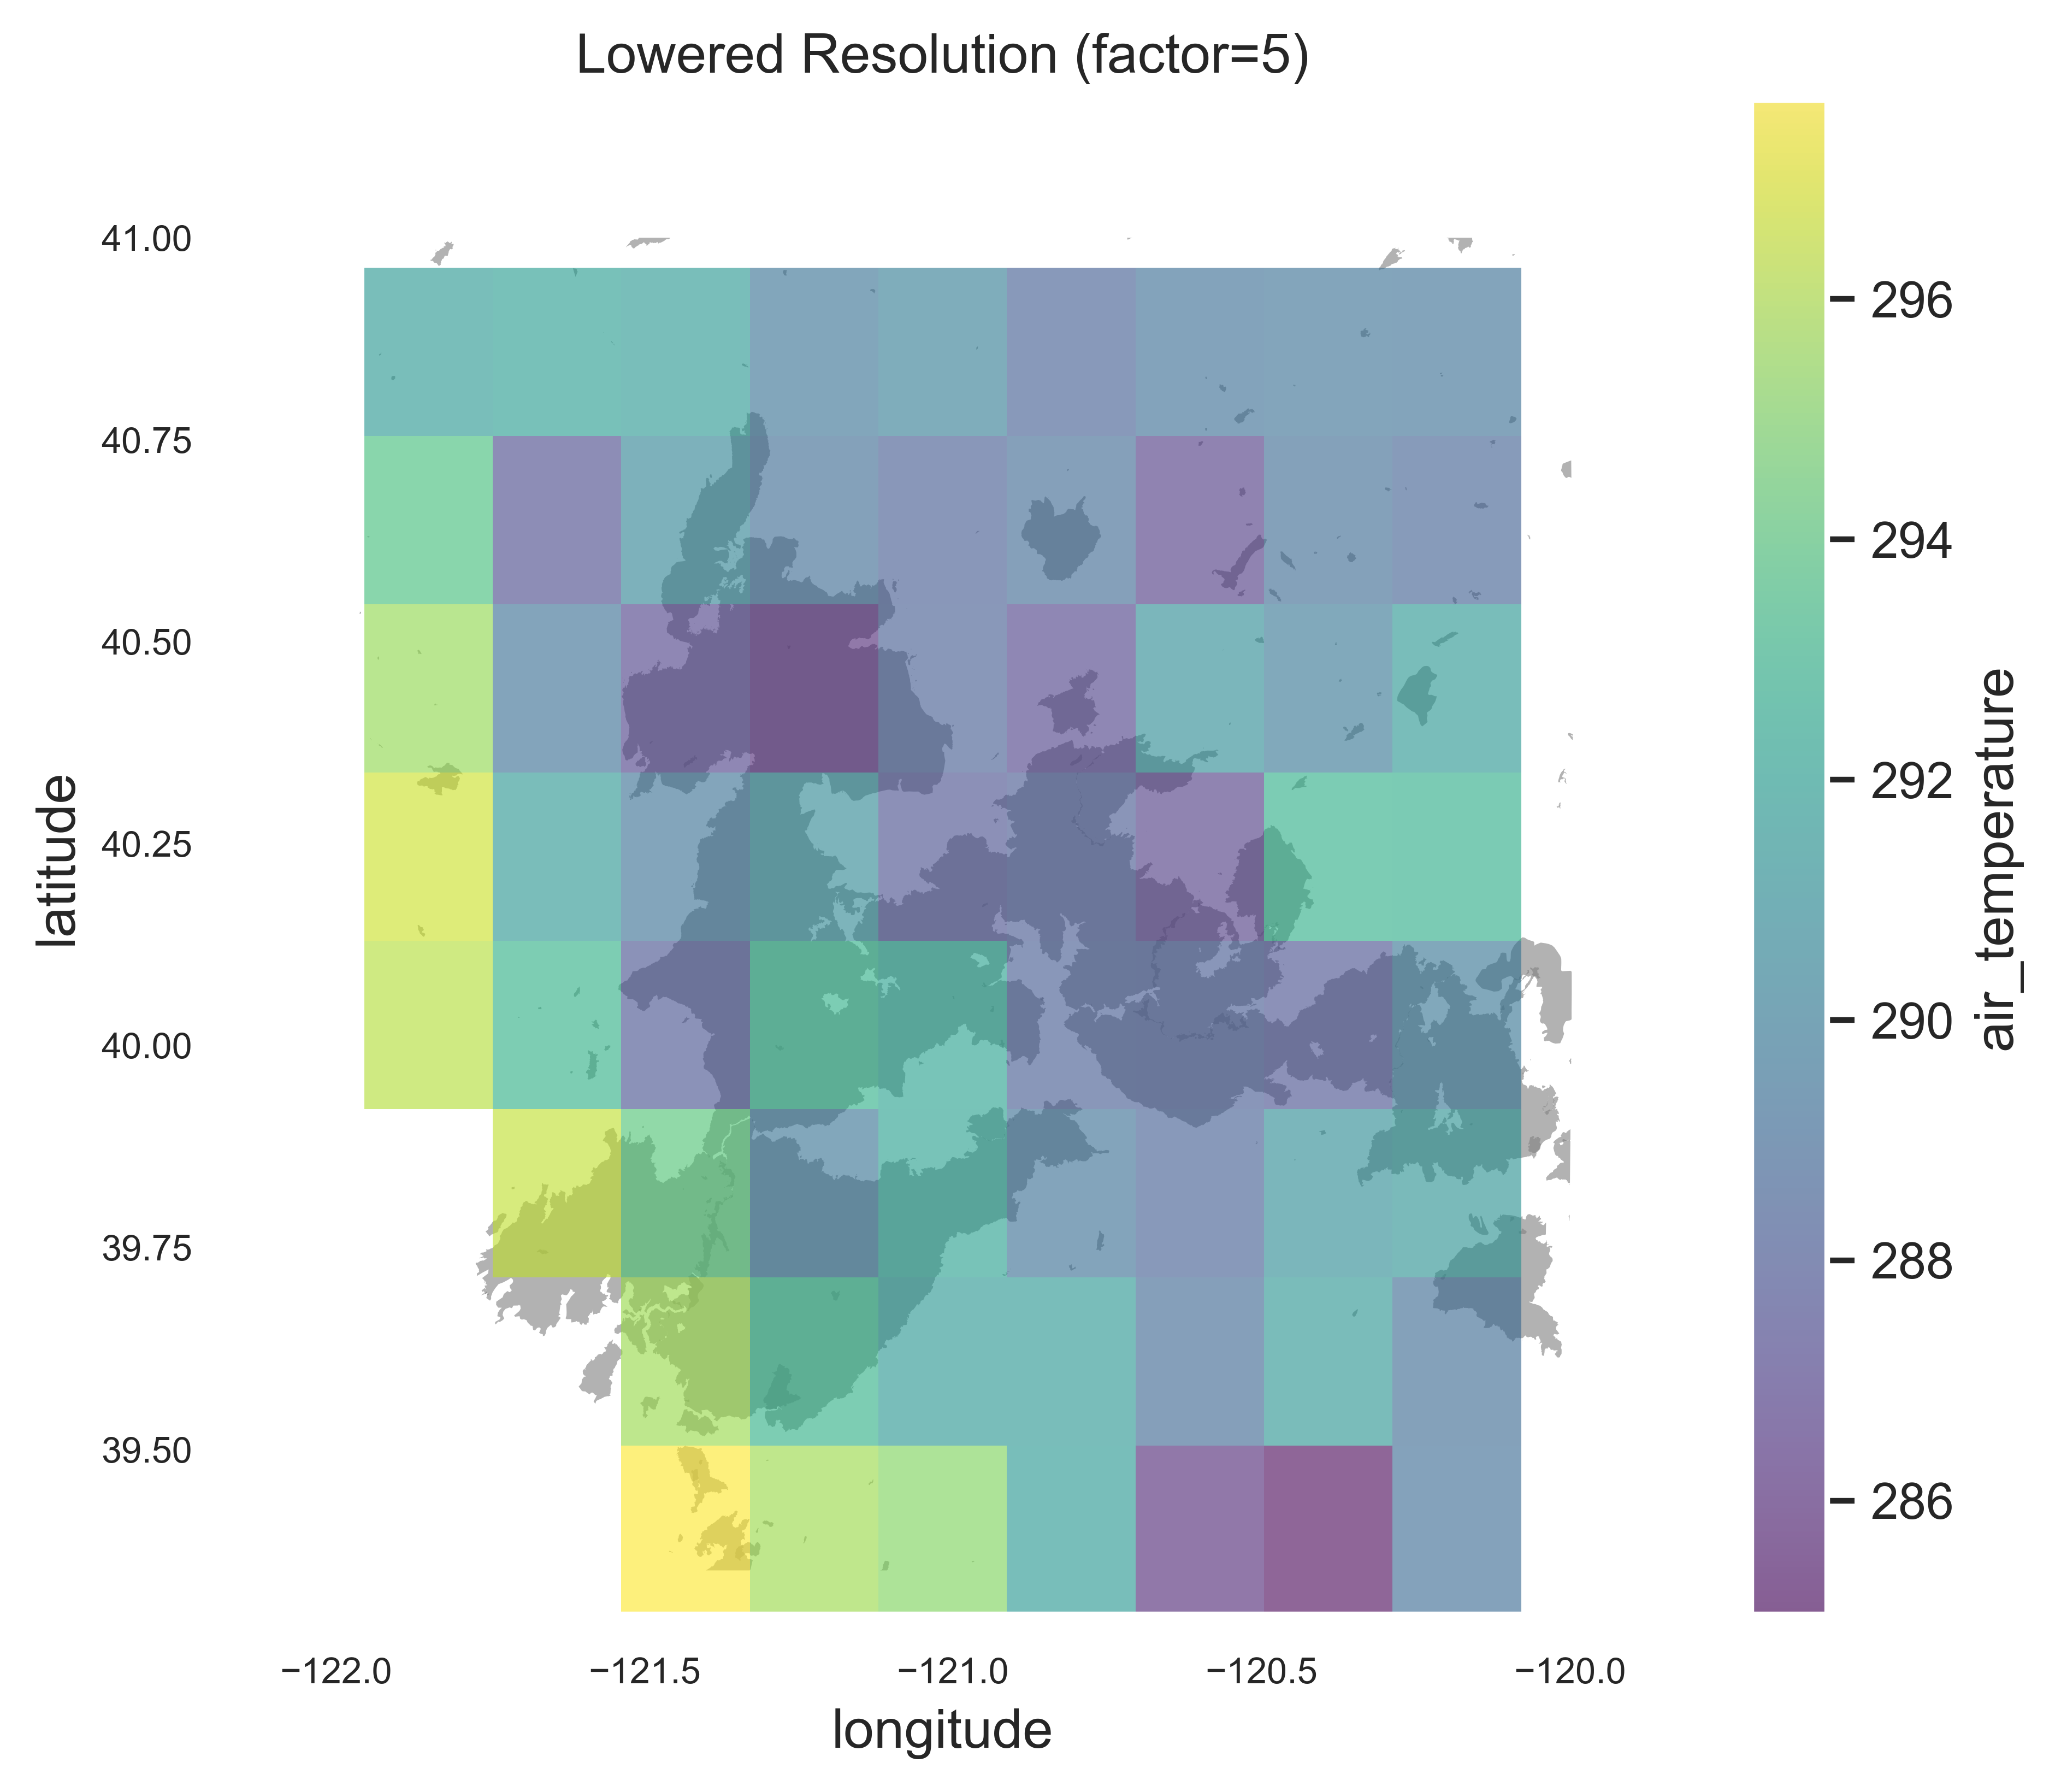

In [12]:
# lower resolution by factor x
factor = 5
inter = ds.interp(lon=ds.lon.to_numpy()[0::factor], 
                  lat=ds.lat.to_numpy()[0::factor], 
                  method="linear")
fig, ax = plt.subplots(nrows=1, ncols=1)
firePer.plot(alpha=0.6, linewidth=0, color='grey',ax=ax);
inter.air_temperature.mean('day').plot(alpha=0.6, ax=ax);
plt.title(f'Lowered Resolution (factor={factor})');
plt.tick_params(axis='both', which='major', labelsize=8);
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(False);
ax.set_facecolor('white');

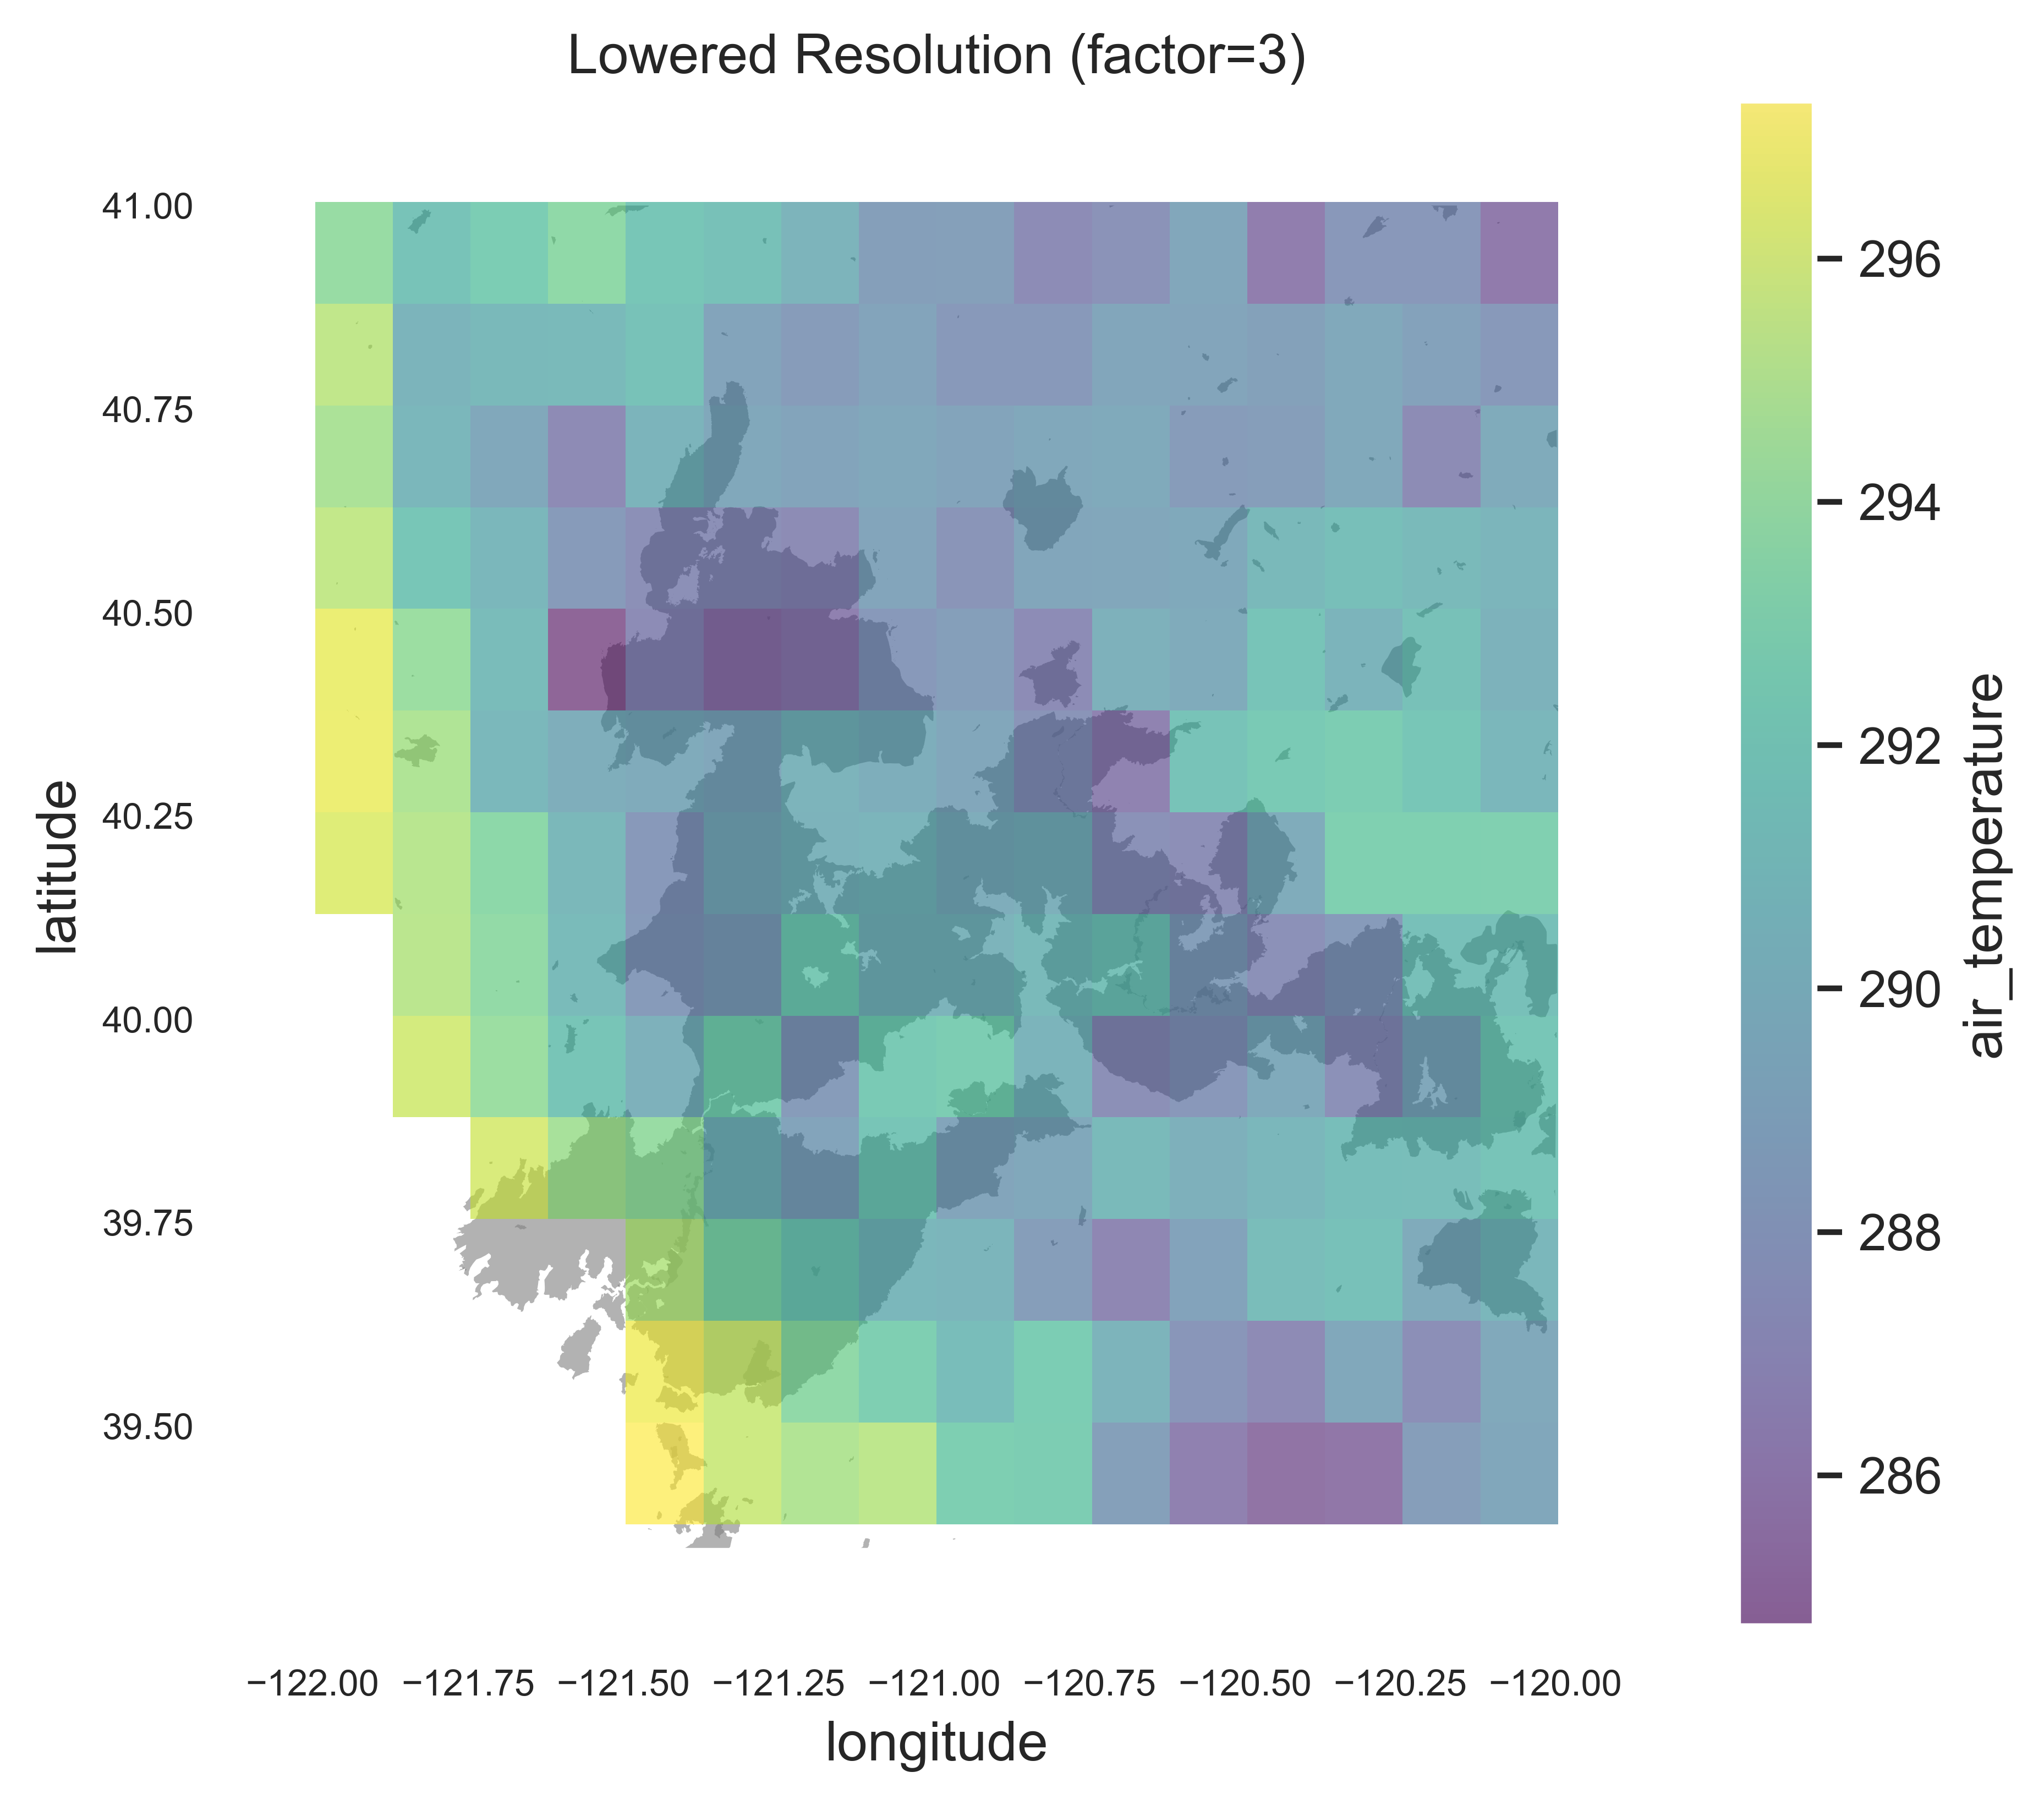

In [13]:
# lower resolution by factor x
factor = 3
inter3 = ds.interp(lon=ds.lon.to_numpy()[0::factor], 
                  lat=ds.lat.to_numpy()[0::factor], 
                  method="linear")
fig, ax = plt.subplots(nrows=1, ncols=1)
firePer.plot(alpha=0.6, linewidth=0, color='grey',ax=ax);
inter3.air_temperature.mean('day').plot(alpha=0.6, ax=ax);
plt.title(f'Lowered Resolution (factor={factor})');
plt.tick_params(axis='both', which='major', labelsize=8);
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(False);
ax.set_facecolor('white');

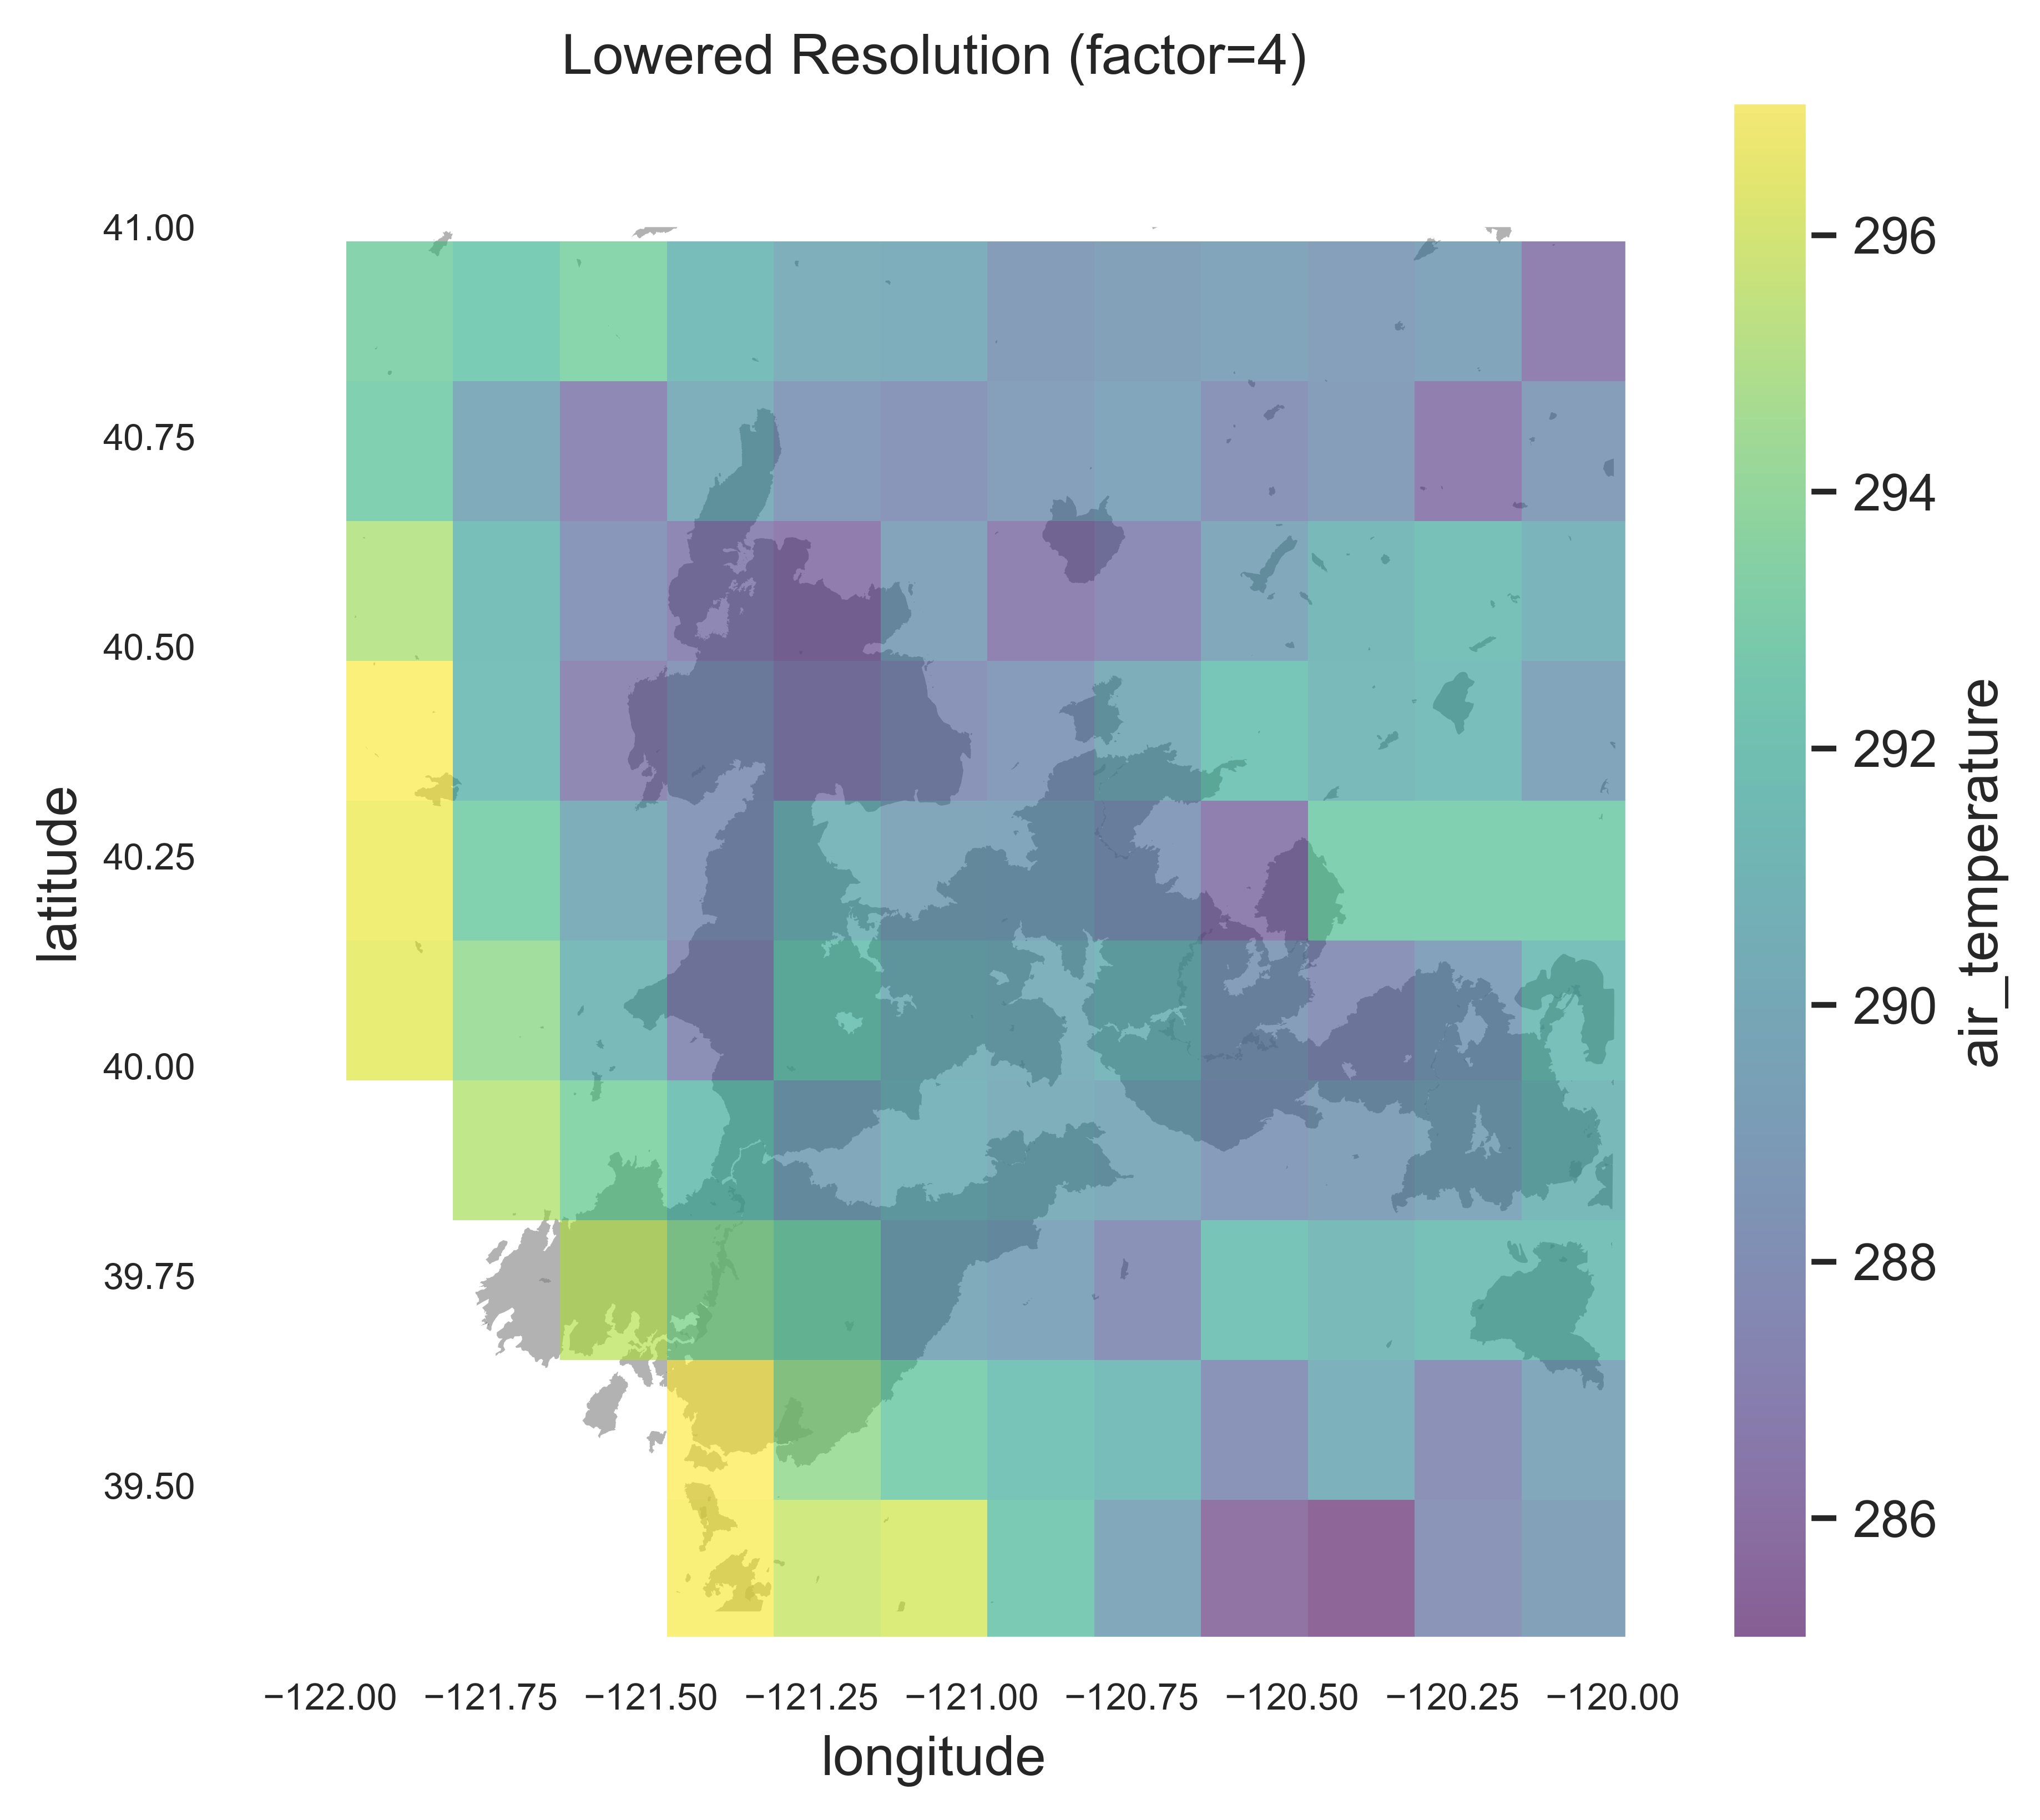

In [14]:
# lower resolution by factor x
factor = 4
inter4 = ds.interp(lon=ds.lon.to_numpy()[0::factor], 
                  lat=ds.lat.to_numpy()[0::factor], 
                  method="linear")
fig, ax = plt.subplots(nrows=1, ncols=1)
firePer.plot(alpha=0.6, linewidth=0, color='grey',ax=ax);
inter4.air_temperature.mean('day').plot(alpha=0.6, ax=ax);
plt.title(f'Lowered Resolution (factor={factor})');
plt.tick_params(axis='both', which='major', labelsize=8);
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid(False);
ax.set_facecolor('white');

In [15]:
inter

<xarray.Dataset>
Dimensions:            (day: 1826, lat: 9, lon: 11)
Coordinates:
  * day                (day) datetime64[ns] 2017-01-01 2017-01-02 ... 2021-12-31
  * lon                (lon) float64 -122.1 -121.8 -121.6 ... -120.2 -120.0
  * lat                (lat) float64 41.07 40.86 40.65 ... 39.82 39.61 39.4
Data variables:
    burning_index_g    (day, lat, lon) float64 nan nan nan nan ... 0.0 10.0 nan
    relative_humidity  (day, lat, lon) float64 nan nan nan nan ... 59.5 56.1 nan
    air_temperature    (day, lat, lon) float64 nan nan nan ... 269.4 273.6 nan
    wind_speed         (day, lat, lon) float64 nan nan nan nan ... 3.0 4.0 nan
Attributes:
    units:              Unitless
    description:        BI-G
    long_name:          bi
    standard_name:      bi
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326

In [16]:
# new lowered resolution
print(abs(np.diff(inter.lon.to_numpy())))
print(abs(np.diff(inter.lat.to_numpy())))
res = abs(np.diff(inter.lon.to_numpy()))[0]

[0.20833333 0.20833333 0.20833333 0.20833333 0.20833333 0.20833333
 0.20833333 0.20833333 0.20833333 0.20833333]
[0.20833333 0.20833333 0.20833333 0.20833333 0.20833333 0.20833333
 0.20833333 0.20833333]


# Fire Column

- 0: no fire at coordinate that day
- 1: first day of fire

- corrdinates (lon, lat) are centers of pixels, create bigger polygons (squares) to include area around coordinate
- check if coordinates intersect fire perimeters
    - 0: no intersection
    - 1: yes intersection
- check if dates had a fire
    - 0: no fire at coordinate that day
    - 1: yes fire
- determine if coordinates on a day had fire

- https://gis.stackexchange.com/questions/375407/geopandas-intersects-doesnt-find-any-intersection


In [17]:
# expand coordinate points to include area around it
def getSquare(lon, lat, res):
    return Polygon([(lon+res/2,lat+res/2), (lon+res/2,lat-res/2), 
                    (lon-res/2,lat-res/2), (lon-res/2,lat+res/2)])
df = inter.to_dataframe().dropna().reset_index()
df['point'] = df.apply(lambda x: getSquare(x['lon'], x['lat'], res), axis=1)

pp = gpd.GeoSeries(df.drop_duplicates(['lat', 'lon']).point)
inp, res = firePer.geometry.sindex.query_bulk(pp, predicate='intersects')
intersects = np.isin(np.arange(0, len(pp)), inp)
intersects = np.tile(intersects,ds.day.shape[0])
df['intersects'] = intersects
df['intersects'].value_counts()

True     102256
False     20086
Name: intersects, dtype: int64

In [18]:
# check if dates had fire (no, first day, others)
fireDate = set()
# otherDay = set()
for i in range(len(firePer)):
    fire = df[firePer.ALARM_DATE[i] <= df.day][df.day <= firePer.CONT_DATE[i]]
    for f in (fire.index): fireDate.add(f)
df['fireDate'] = 0
df['fireDate'][fireDate] = 1
df['fireDate'].value_counts()

0    63047
1    59295
Name: fireDate, dtype: int64

In [19]:
# determine if coordinates on a day had fire
# (intersects, fireDate) -> fire
# (0, 1) -> 0
# (1, 0) -> 0
# (1, 1) -> 1
df['fire'] = np.where(((df.intersects==0) | (df.fireDate==0)), 0, 1)
df['fire'].value_counts()

0    72782
1    49560
Name: fire, dtype: int64

# Season Column
- determine season based on date

In [20]:
# spring: 3/20 - 6/20         summer: 6/21 - 9/22
# autumn: 9/23 - 12/20        winter: 12/21 - 3/19
df['season'] = (df['day'].dt.month*100 + df['day'].dt.day - 320) % 1300
df['season'] = pd.cut(df['season'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'],
                      include_lowest = True)
df['season'] = pd.Categorical(df['season'], ['spring', 'summer', 'autumn', 'winter'])
df.season.value_counts()

summer    31490
spring    31155
winter    29882
autumn    29815
Name: season, dtype: int64

# Final Dataframe

In [21]:
# get useful columns
final = df[['day', 'season', 'burning_index_g', 'relative_humidity', 'air_temperature', 'wind_speed', 'fire']]
final#.head()

day  season  burning_index_g  relative_humidity  \
0      2017-01-01  winter              0.0          55.100002   
1      2017-01-01  winter              0.0          43.700001   
2      2017-01-01  winter              0.0          47.799999   
3      2017-01-01  winter              0.0          63.900002   
4      2017-01-01  winter              0.0          53.299999   
...           ...     ...              ...                ...   
122337 2021-12-31  winter              2.0          53.900002   
122338 2021-12-31  winter              7.0          54.200001   
122339 2021-12-31  winter              0.0          47.700001   
122340 2021-12-31  winter              0.0          59.500000   
122341 2021-12-31  winter             10.0          56.100002   

        air_temperature  wind_speed  fire  
0            273.799988         4.6     0  
1            277.000000         4.8     0  
2            276.000000         5.1     0  
3            272.100006         5.6     0  
4            273.299988         6.0     0  
...                 ...         ...   ...  
122337       280.200012         1.4     0  
122338       276.700012         2.2     0  
122339       271.700012         2.9     0  
122340       269.399994         3.0     0  
122341       273.600006         4.0     0  

[122342 rows x 7 columns]

In [22]:
# save as pickle file
with open('data/gridmet.pkl', 'wb')     as f: pkl.dump(final.to_numpy(), f) # save dict
with open('data/gridmetCols.pkl', 'wb') as f: pkl.dump(final.columns,    f) # save dict

aa = pd.DataFrame(pd.read_pickle('data/gridmet.pkl'))
aa.columns = pd.read_pickle('data/gridmetCols.pkl')
aa.head()

day  season burning_index_g relative_humidity air_temperature  \
0 2017-01-01  winter             0.0         55.100002      273.799988   
1 2017-01-01  winter             0.0         43.700001           277.0   
2 2017-01-01  winter             0.0         47.799999           276.0   
3 2017-01-01  winter             0.0         63.900002      272.100006   
4 2017-01-01  winter             0.0         53.299999      273.299988   

  wind_speed fire  
0        4.6    0  
1        4.8    0  
2        5.1    0  
3        5.6    0  
4        6.0    0

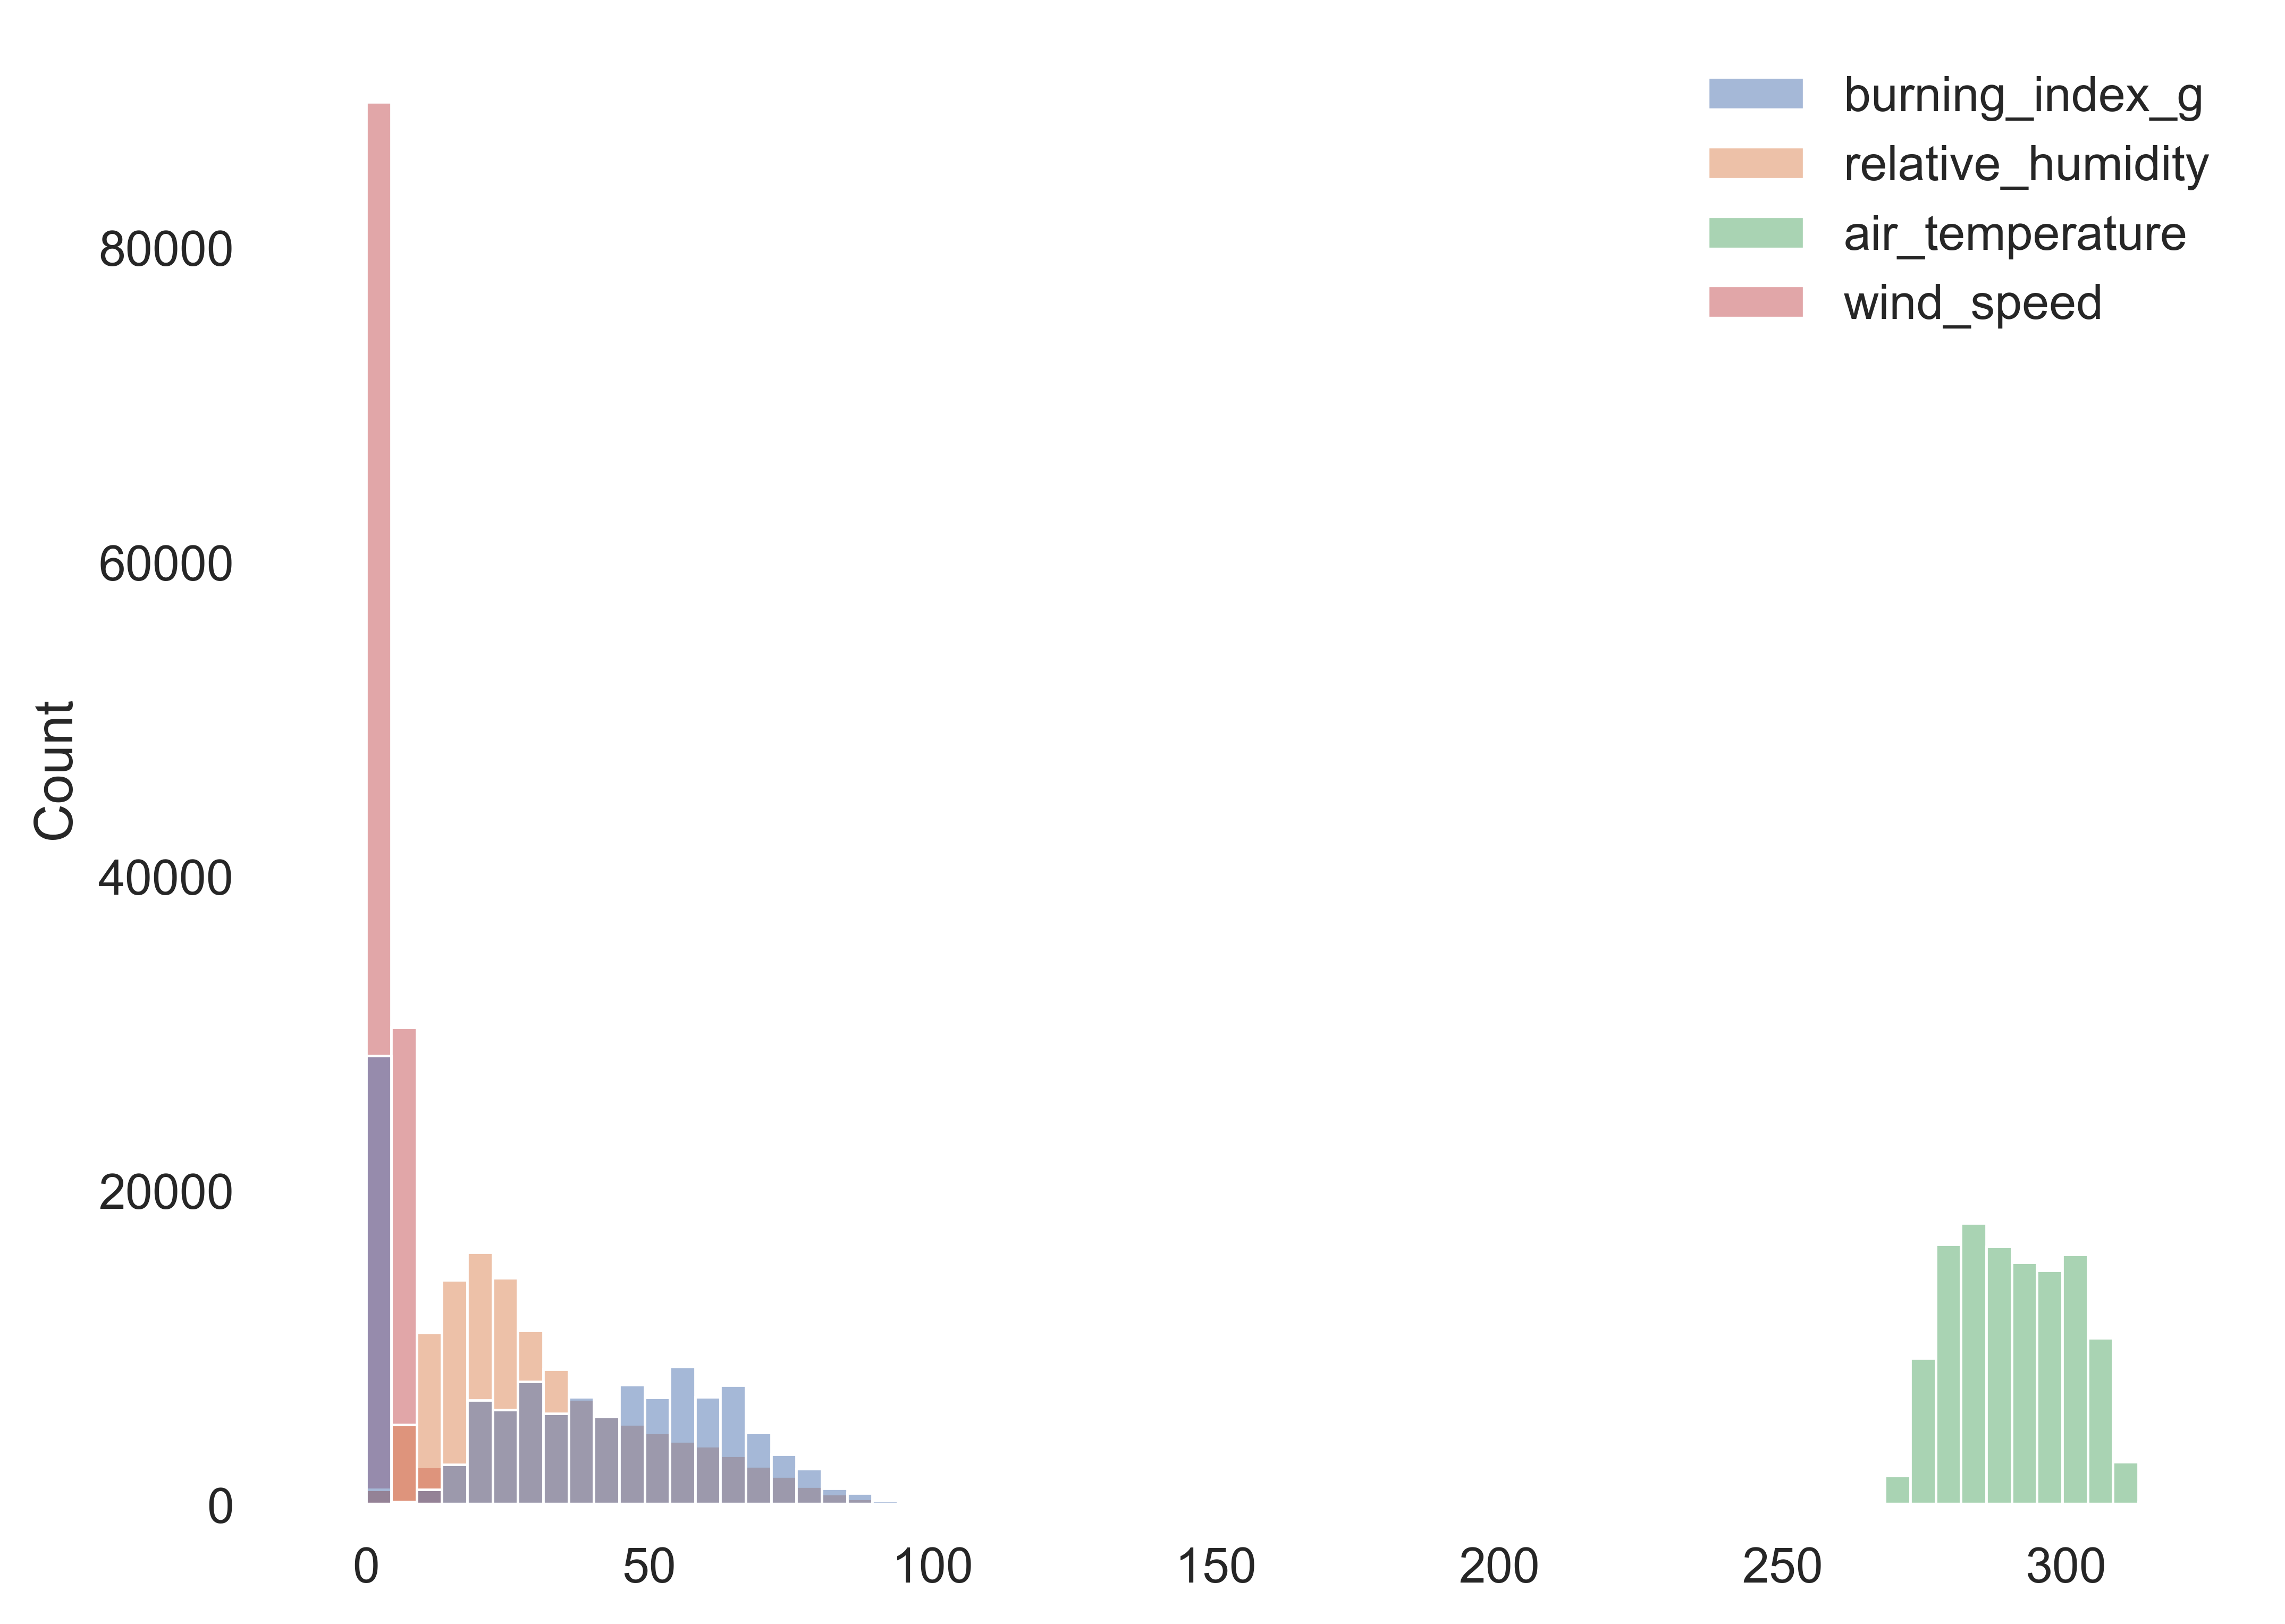

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.histplot(aa.drop(['day', 'fire'], axis=1), ax=ax);
plt.grid(False);
ax.set_facecolor('white');

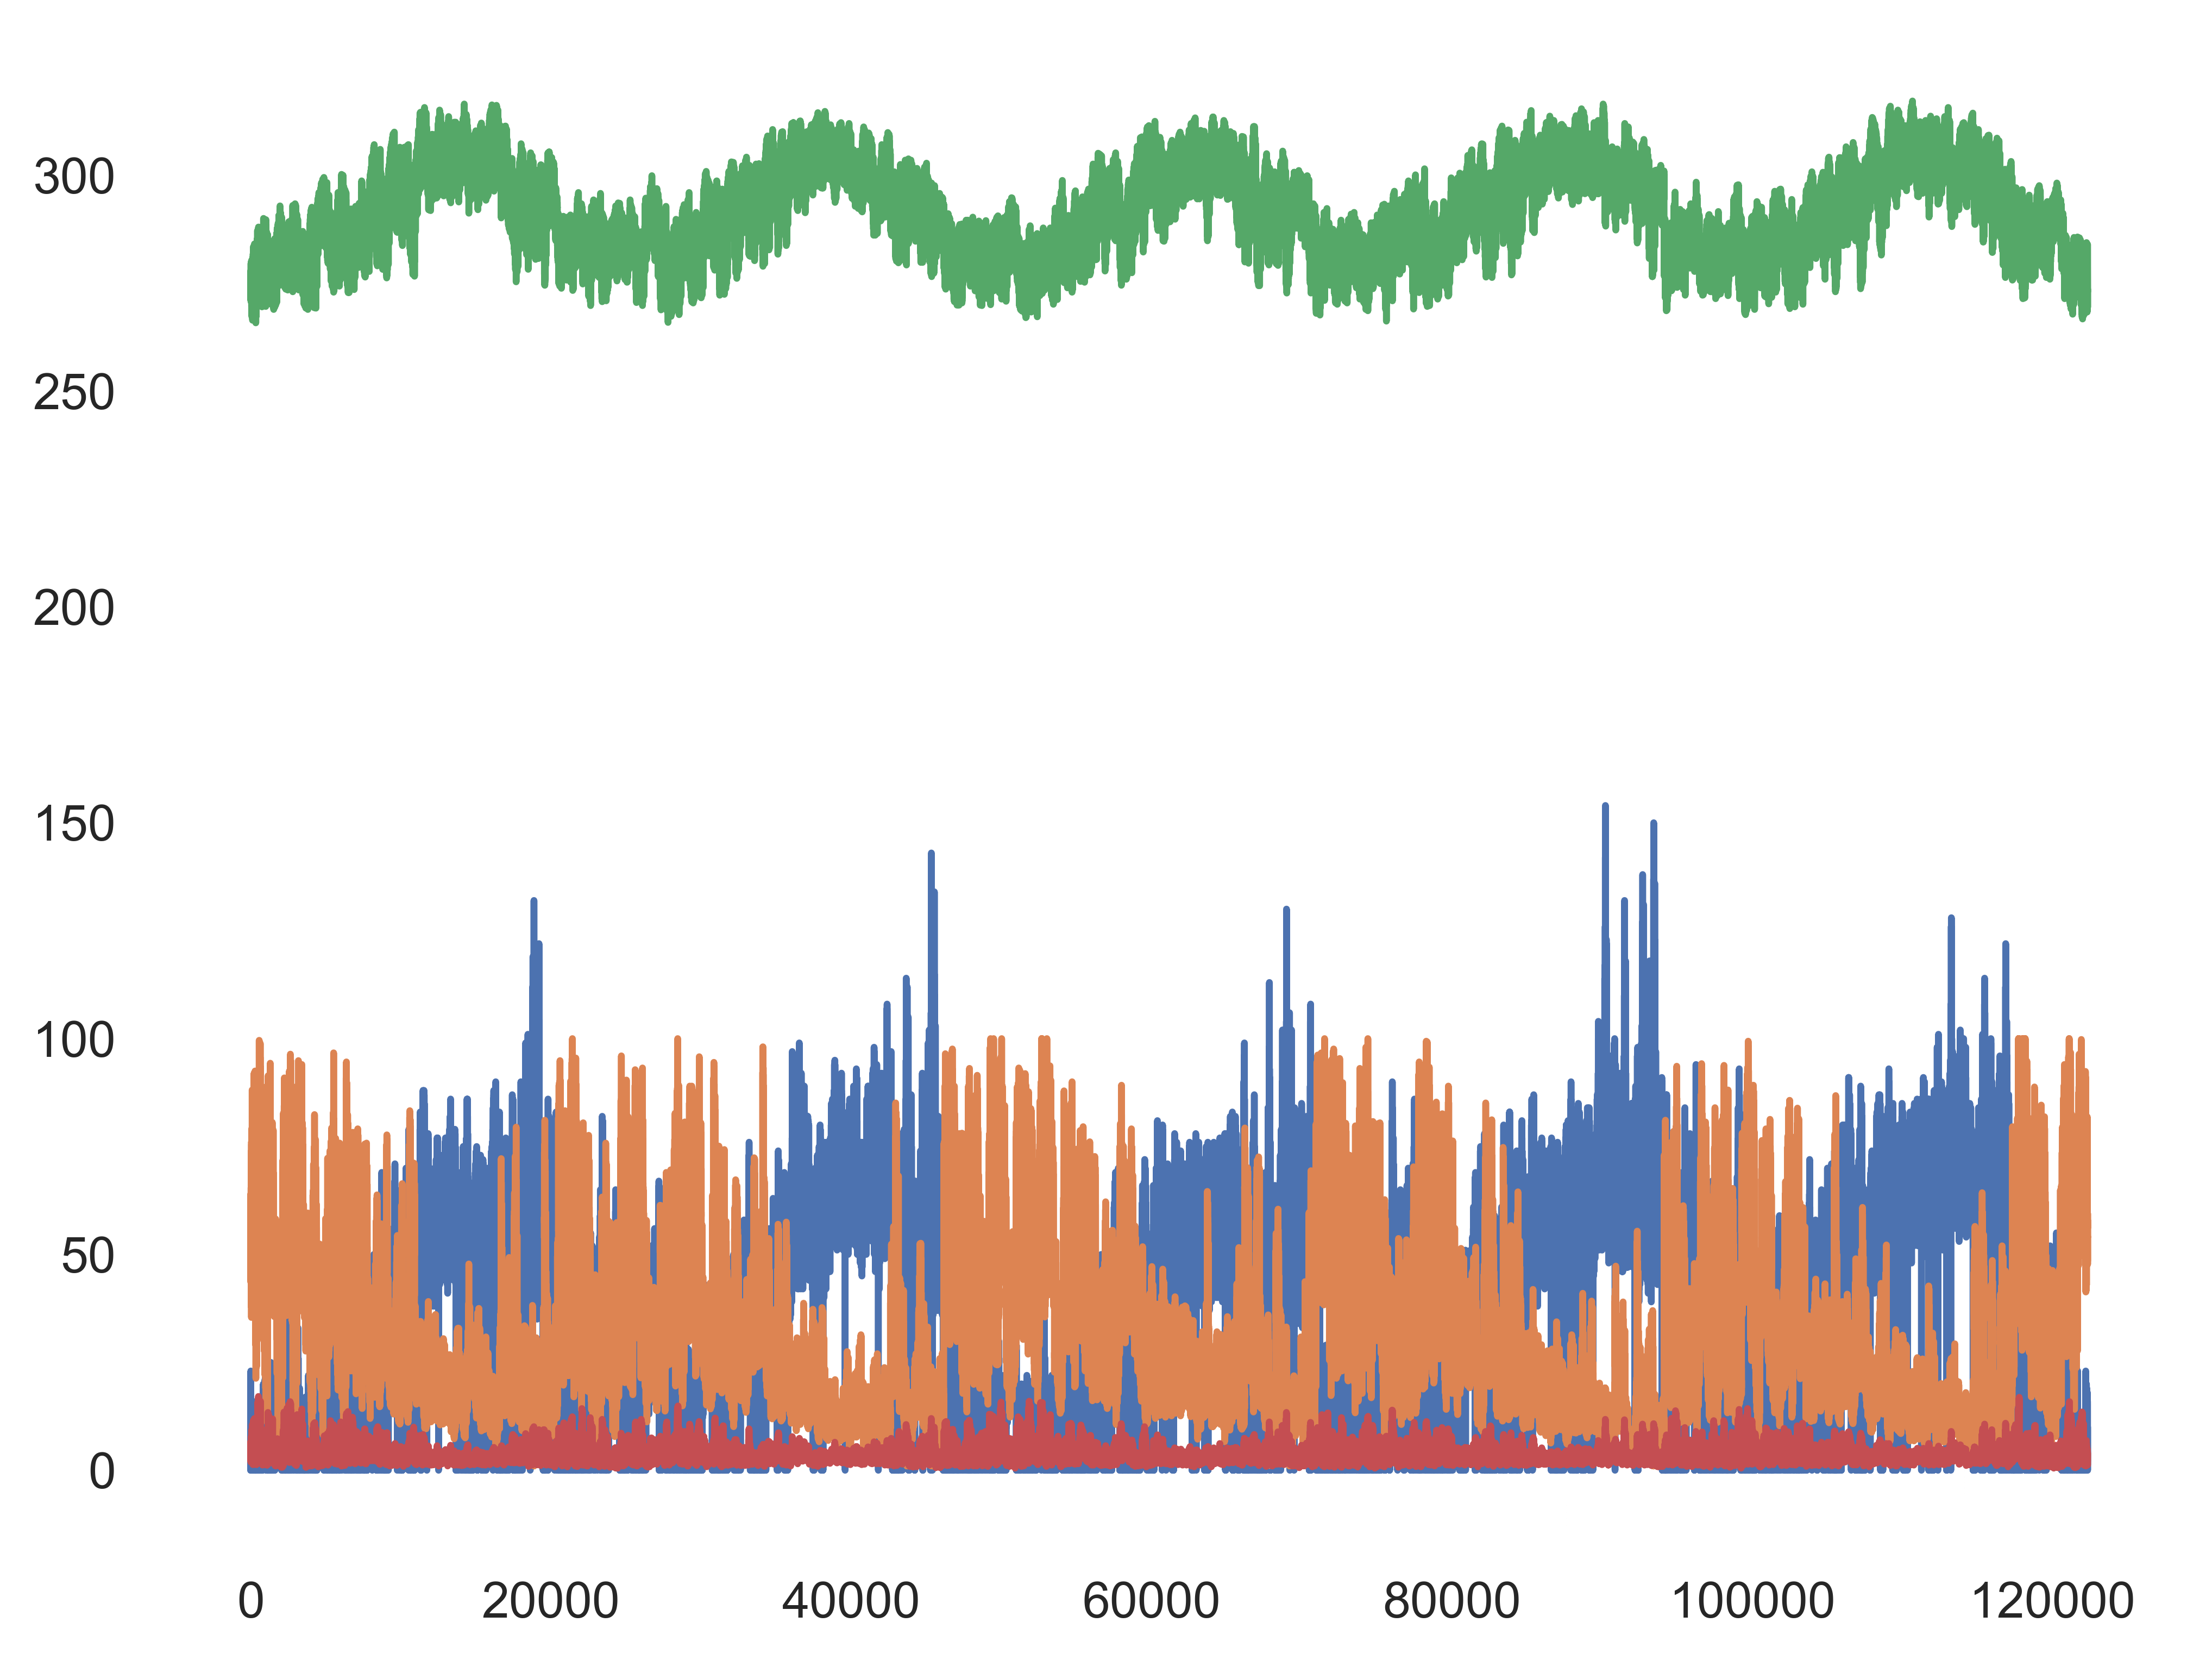

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(aa.drop(['day', 'season', 'fire'], axis=1));
plt.grid(False);
ax.set_facecolor('white');

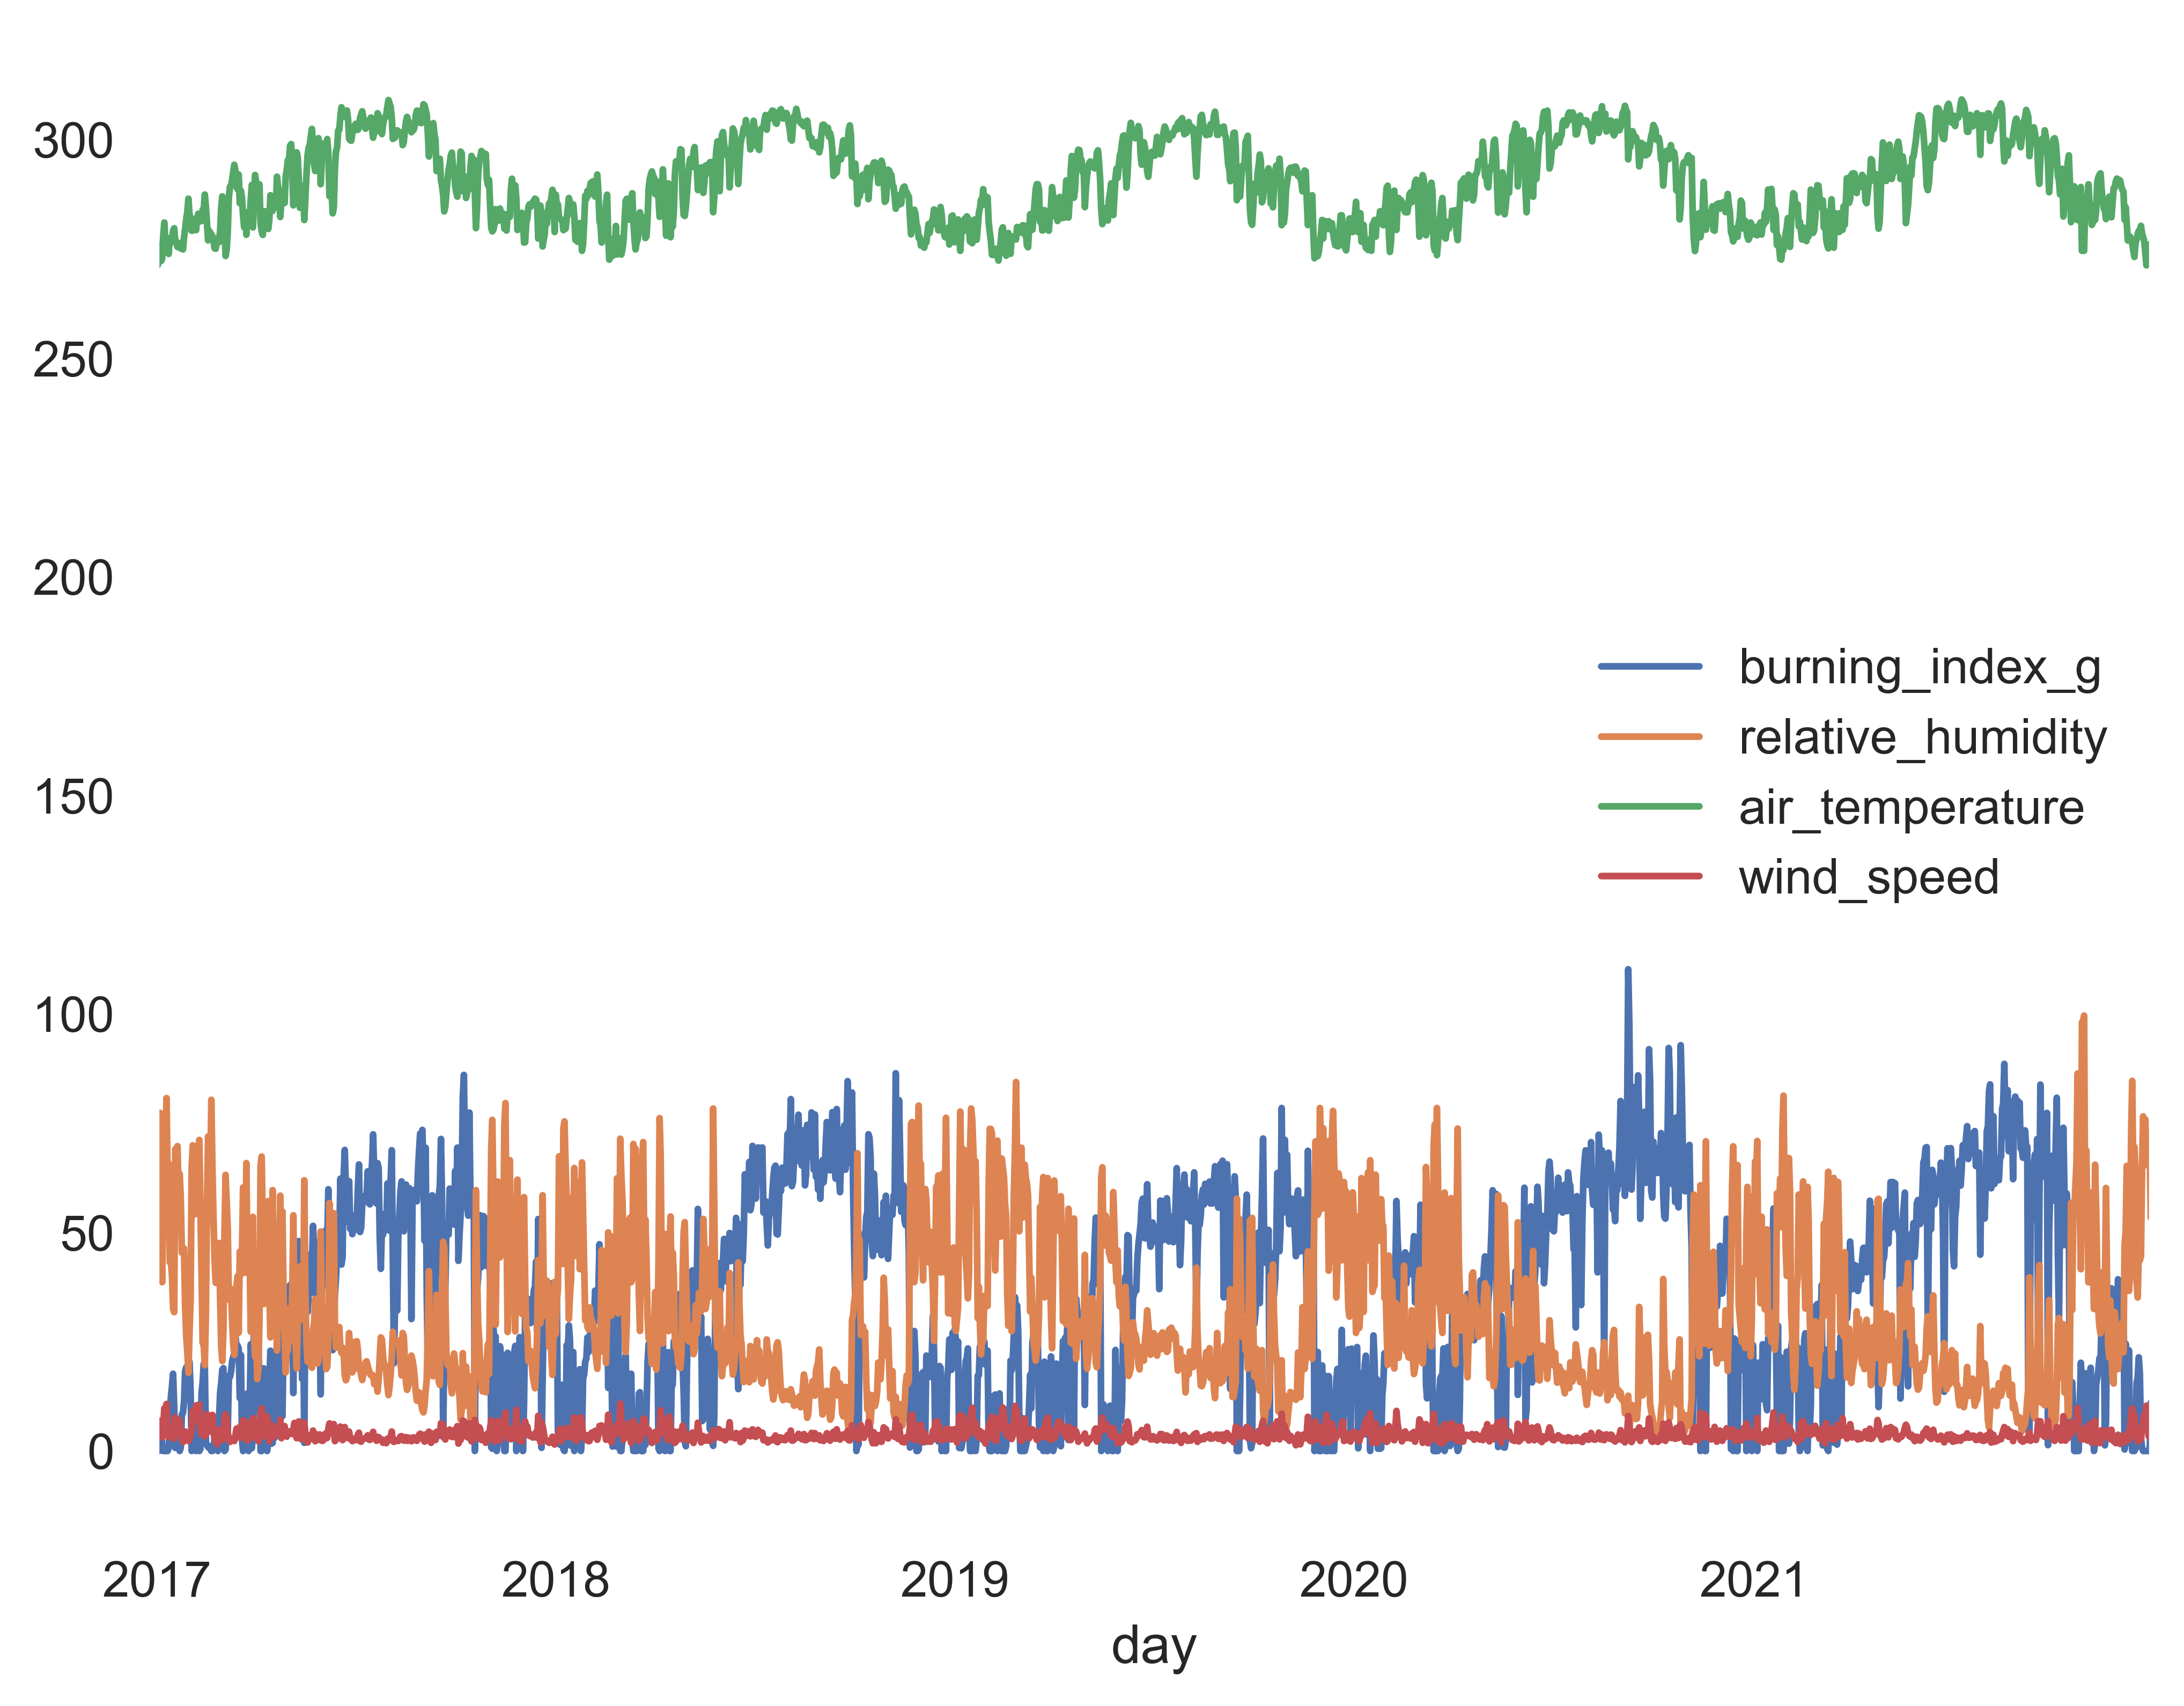

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1)
aa.groupby('day').mean().drop(['fire'], axis=1).plot(ax=ax)
plt.grid(False);
ax.set_facecolor('white');

In [26]:
aa.drop(['day', 'season'], axis=1).astype(float).describe()

burning_index_g  relative_humidity  air_temperature     wind_speed  \
count    122342.000000      122342.000000    122342.000000  122342.000000   
mean         35.748745          31.604289       290.474329       3.849427   
std          25.696133          18.678158        10.084673       1.814981   
min           0.000000           1.000000       265.799988       0.500000   
25%          15.000000          17.600000       282.100006       2.600000   
50%          37.000000          26.500000       290.000000       3.400000   
75%          57.000000          42.600002       299.100006       4.600000   
max         154.000000         100.000000       317.200012      17.100000   

                fire  
count  122342.000000  
mean        0.405094  
std         0.490912  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

### Code Dump

In [27]:
# # THIS DOESN'T WORK: a date can be both first and other fire days
# # check if dates had fire (no, first day, others)
# firstDay = set()
# otherDay = set()
# for i in range(len(firePer)):
#     first = df[df.day == firePer.ALARM_DATE[i]]
#     other = df[df.day >  firePer.ALARM_DATE[i]][df.day <= firePer.CONT_DATE[i]]
#     for f in (first.index): firstDay.add(f)
#     for o in (other.index): otherDay.add(o)
# df['fireDate'] = 0
# df['fireDate'][firstDay] = 1
# df['fireDate'][otherDay] = 2
# df['fireDate'].value_counts()

# # determine if coordinates on a day had fire
# # (intersects, fireDate) -> fire
# # (0, {0,1,2}) -> 0
# # (1, 0)       -> 0
# # (1, 1)       -> 1
# # (1, 2)       -> 2
# df['intersects'] = np.where(((df.intersects==0) | (df.fireDate==0)), 0, df.intersects)
# df['fireDate']   = np.where(((df.intersects==0) | (df.fireDate==0)), 0, df.fireDate)
# df['fire'] = 0
# df['fire'] = np.where(df.fireDate==1, 1, df.intersects)
# df['fire'] = np.where(df.fireDate==2, 2, df.intersects)